# 0.0 IMPORTS

## 0.1 Helper Functions

In [1]:
import math
import pandas as pd
import inflection
import seaborn as sns
import matplotlib. pyplot as plt

from IPython.display import Image
from IPython.core.display import HTML

In [2]:
def jupyter_settings(): 
    %matplotlib inline 
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') ) 
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [3]:
df_sales_raw = pd.read_csv('data/rossmann_store_sales/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/rossmann_store_sales/store.csv', low_memory=False)

# Merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')
df_raw.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
889408,424,4,2013-04-25,5271,674,1,1,0,0,d,c,1250.0,NaN,NaN,1,40.0,2011.0,"Jan,Apr,Jul,Oct"
190427,878,3,2015-02-11,5825,625,1,0,0,1,d,c,1100.0,12.0,2014.0,0,NaN,NaN,NaN
403229,499,7,2014-07-06,0,0,0,0,0,0,c,c,450.0,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"
256735,864,3,2014-12-10,3843,516,1,0,0,0,a,a,1020.0,10.0,2012.0,1,45.0,2009.0,"Feb,May,Aug,Nov"
225149,1035,7,2015-01-11,0,0,0,0,0,0,a,a,27150.0,NaN,NaN,0,NaN,NaN,NaN


# 1.0 PASSO 01 - DESCRIÇAO DOS DADOS

In [4]:
df1 = df_raw.copy()

##  1.1 Rename Columns

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# Rename
df1.columns = cols_new

## 1.2 Data Dimensions

In [6]:
print('Number of rows: ', df1.shape[0])
print('Number of cols: ', df1.shape[1])

Number of rows:  1017209
Number of cols:  18


## 1.3 Data Types

In [7]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NAs

In [8]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NAs

In [9]:
df1['competition_distance'].max()

75860.0

In [10]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(
    lambda x: 200000.0 
    if math.isnan( x ) 
    else x )

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply( 
    lambda x: x['date'].month 
    if math.isnan( x['competition_open_since_month'] ) 
    else x['competition_open_since_month'], 
    axis=1 )

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply( 
    lambda x: x['date'].year 
    if math.isnan( x['competition_open_since_year'] ) 
    else x['competition_open_since_year'], 
    axis=1 )

# promo2_since_week
df1['promo2_since_week'] = df1.apply( 
    lambda x: x['date'].week 
    if math.isnan( x['promo2_since_week'] ) 
    else x['promo2_since_week'], 
    axis=1 )

# promo2_since_year
df1['promo2_since_year'] = df1.apply( 
    lambda x: x['date'].year 
    if math.isnan( x['promo2_since_year'] ) 
    else x['promo2_since_year'], 
    axis=1 )

In [11]:
# promo_interval
month_map = {
    1 : 'Jan',
    2 : 'Fev',
    3 : 'Mar',
    4 : 'Apr',
    5 : 'May',
    6 : 'Jun',
    7 : 'Jul',
    8 : 'Aug',
    9 : 'Sep',
    10 : 'Oct',
    11 : 'Nov',
    12 : 'Dec',
}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(
    lambda x: 0 
    if x['promo_interval'] == 0 
    else 1 
    if x['month_map'] in x['promo_interval'].split( ',' ) 
    else 0, 
    axis=1 )

In [12]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [13]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [14]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

In [15]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical

In [16]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )

cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Numerial Attributes

In [17]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenate
m = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
m.columns = [ 'attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]

In [18]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


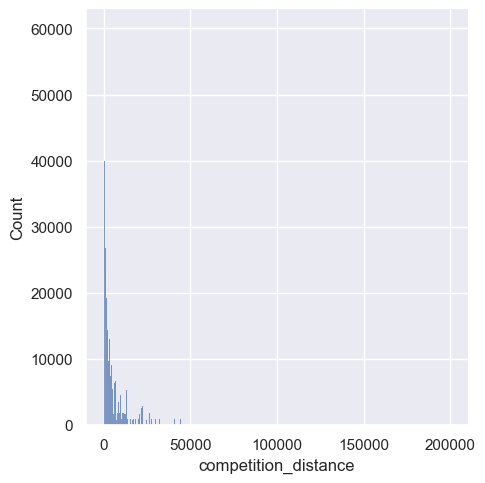

In [19]:
sns.displot( df1['competition_distance'] );


### 1.7.2 Categorical Attributes

In [20]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

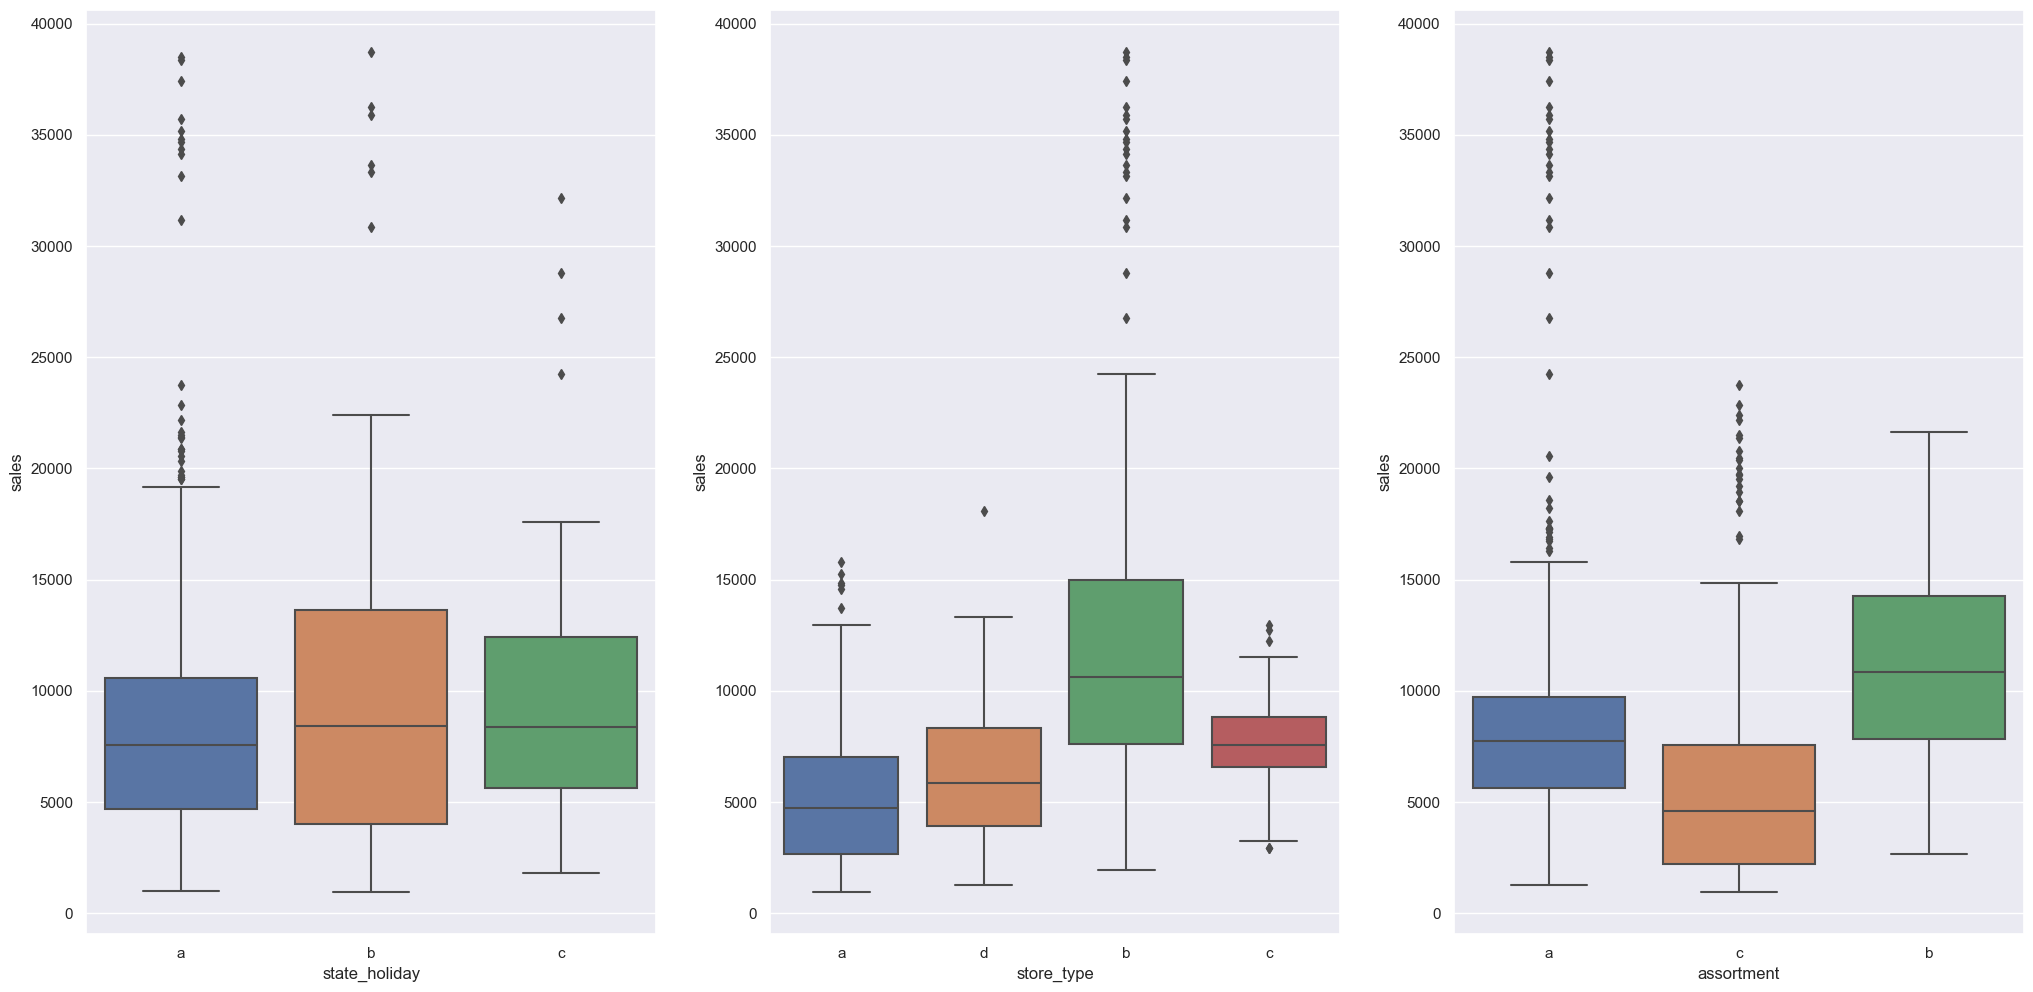

In [21]:
aux1 = df1[ ( df1['state_holiday'] != '0' ) & (df1['sales'] > 0) ]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)
# sns.violinplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)
# sns.violinplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)
# sns.violinplot(x='assortment', y='sales', data=aux1)

# 2.0 PASSO 02 - FEATURE ENGINEERING

In [22]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hiπóteses

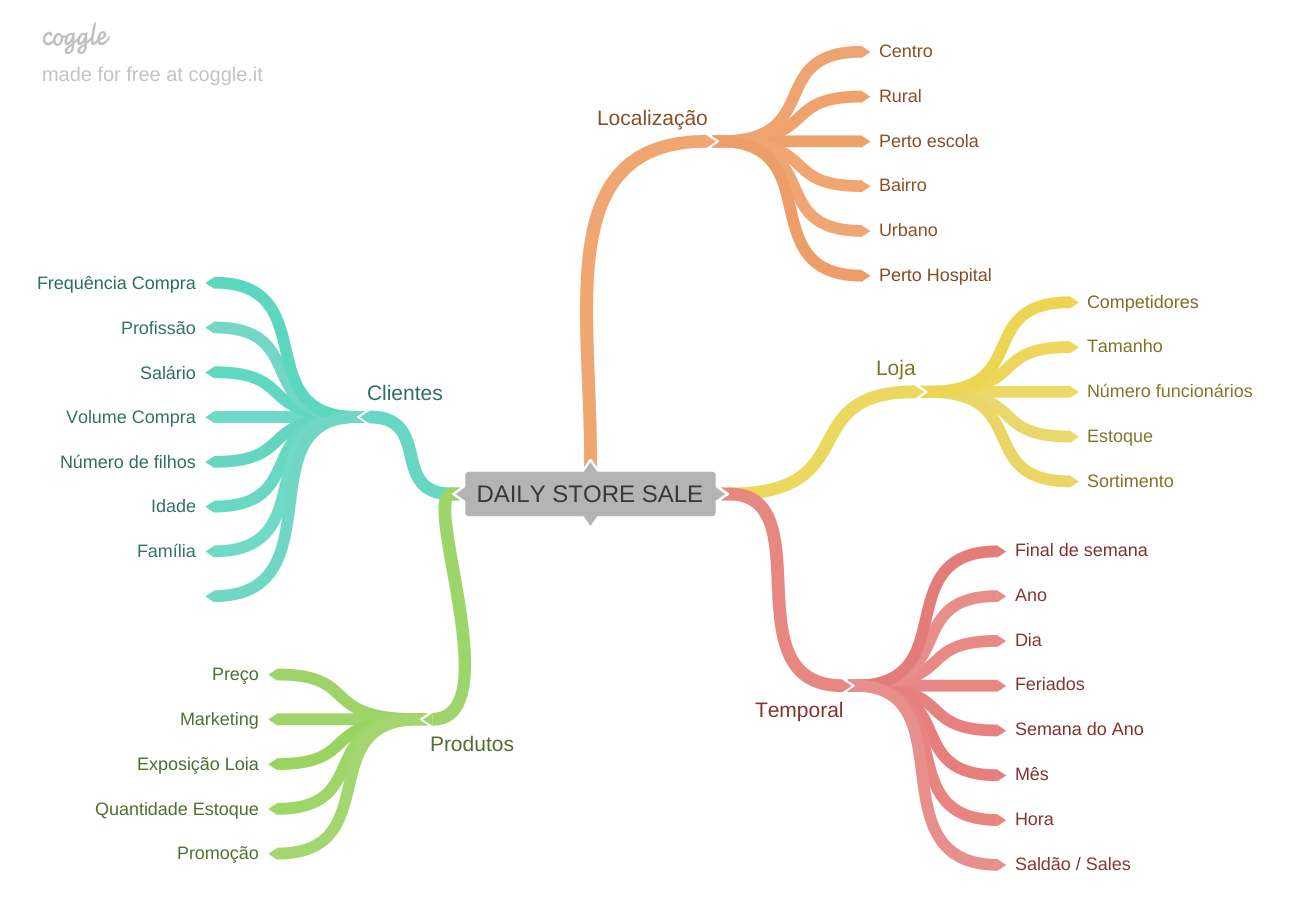

In [23]:
Image('image/MindMapHypothesis.png')

## 2.2 Criação da Hipóteses

### 2.2.1 Hipóteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.2.2 Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Feature Engineering

In [24]:
# year
df2['year'] = df2.date.dt.year

# month
df2['month'] = df2.date.dt.month

# day
df2['day'] = df2.date.dt.day

# week of year
df2['week_of_year'] = df2.date.dt.isocalendar().week

# year week
df2['year_week'] = df2.date.dt.strftime( '%Y-%W' )

# competition_since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis = 1)
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] ) / 30 ).apply( lambda x: x.days ).astype( int )

# promo_since
df2['promo_since'] = df2['promo2_since_year'].astype( 'str' ) + '-' + df2['promo2_since_week'].astype( 'str' )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days = 7 ) )
df2['promo_time_week'] = ( ( df2[ 'date' ] - df2['promo_since' ] ) / 7 ).apply( lambda x: x.days ).astype( int )

# assentassent
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas'if x == 'c' else 'regular_day' )


In [ ]:
# year
df2['year'] = df2['date'].dt.year 

# month
df2['month'] = df2['date'].dt.month 

# day
df2['day'] = df2['date'].dt.day 

# week of year
df2['week_of_year'] = df2['date'].dt.day_name() 

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w'  ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

In [25]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [26]:
df3 = df2.copy()

In [27]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem da Linhas

In [28]:
# a coluna open indica se a loja está aberta ou fechada, e quando a loja está fechada as vendas é zero, é uma relação direta, então não haverá aprendizado, não quero as linhas cuja a coluna 'open' é  igual a zero.
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção da Colunas

In [ ]:
# a coluna customers é uma restrição de negócio, pois não teremos ela disponível no momento da predição.
df3.drop( 'customers', axis = 1 )
df3.drop( 'open', axis = 1 )
df3.drop( 'promo_interval', axis = 1 )
df3.drop( 'month_map', axis = 1 )

In [31]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo', 'year',
       'month', 'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 - PASSO 4 - ANÁLISE EXPLORATÓRIA DOS DADOS

In [32]:
df4 = df3.copy()

## 4.1 - Análise Univariada

### 4.1.1 - Variável Resposta

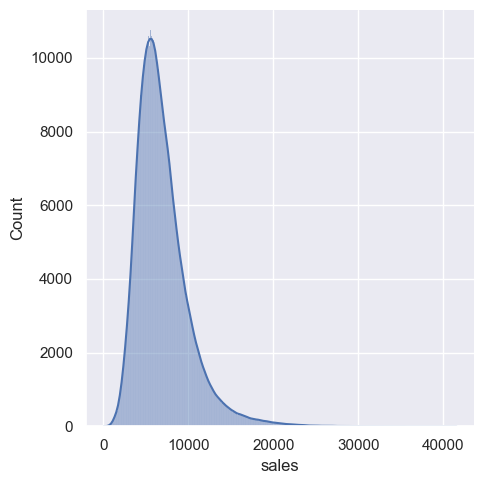

In [33]:
sns.displot( df4['sales'], kde=True );

### 4.1.2 - Numerical Variable

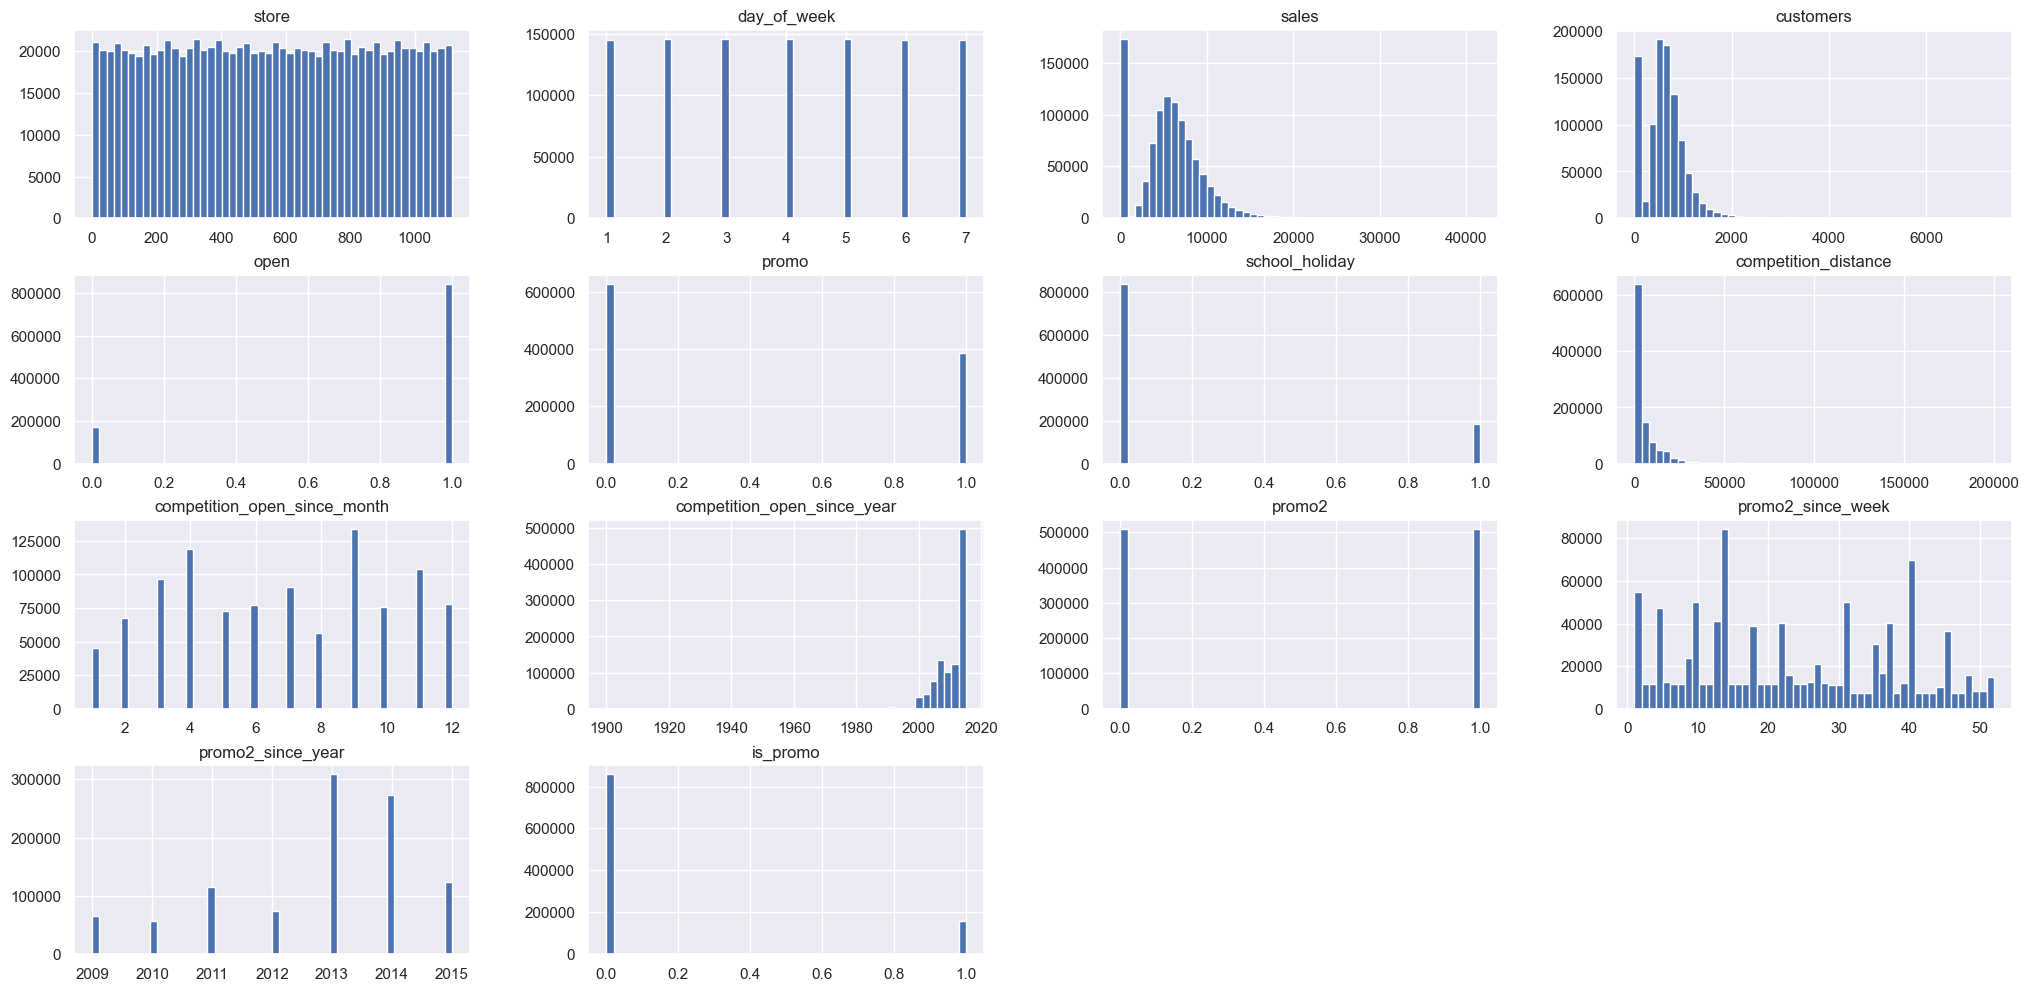

In [34]:
num_attributes.hist( bins=50 );

### 4.1.3 - Categorical Variable

In [35]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [36]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

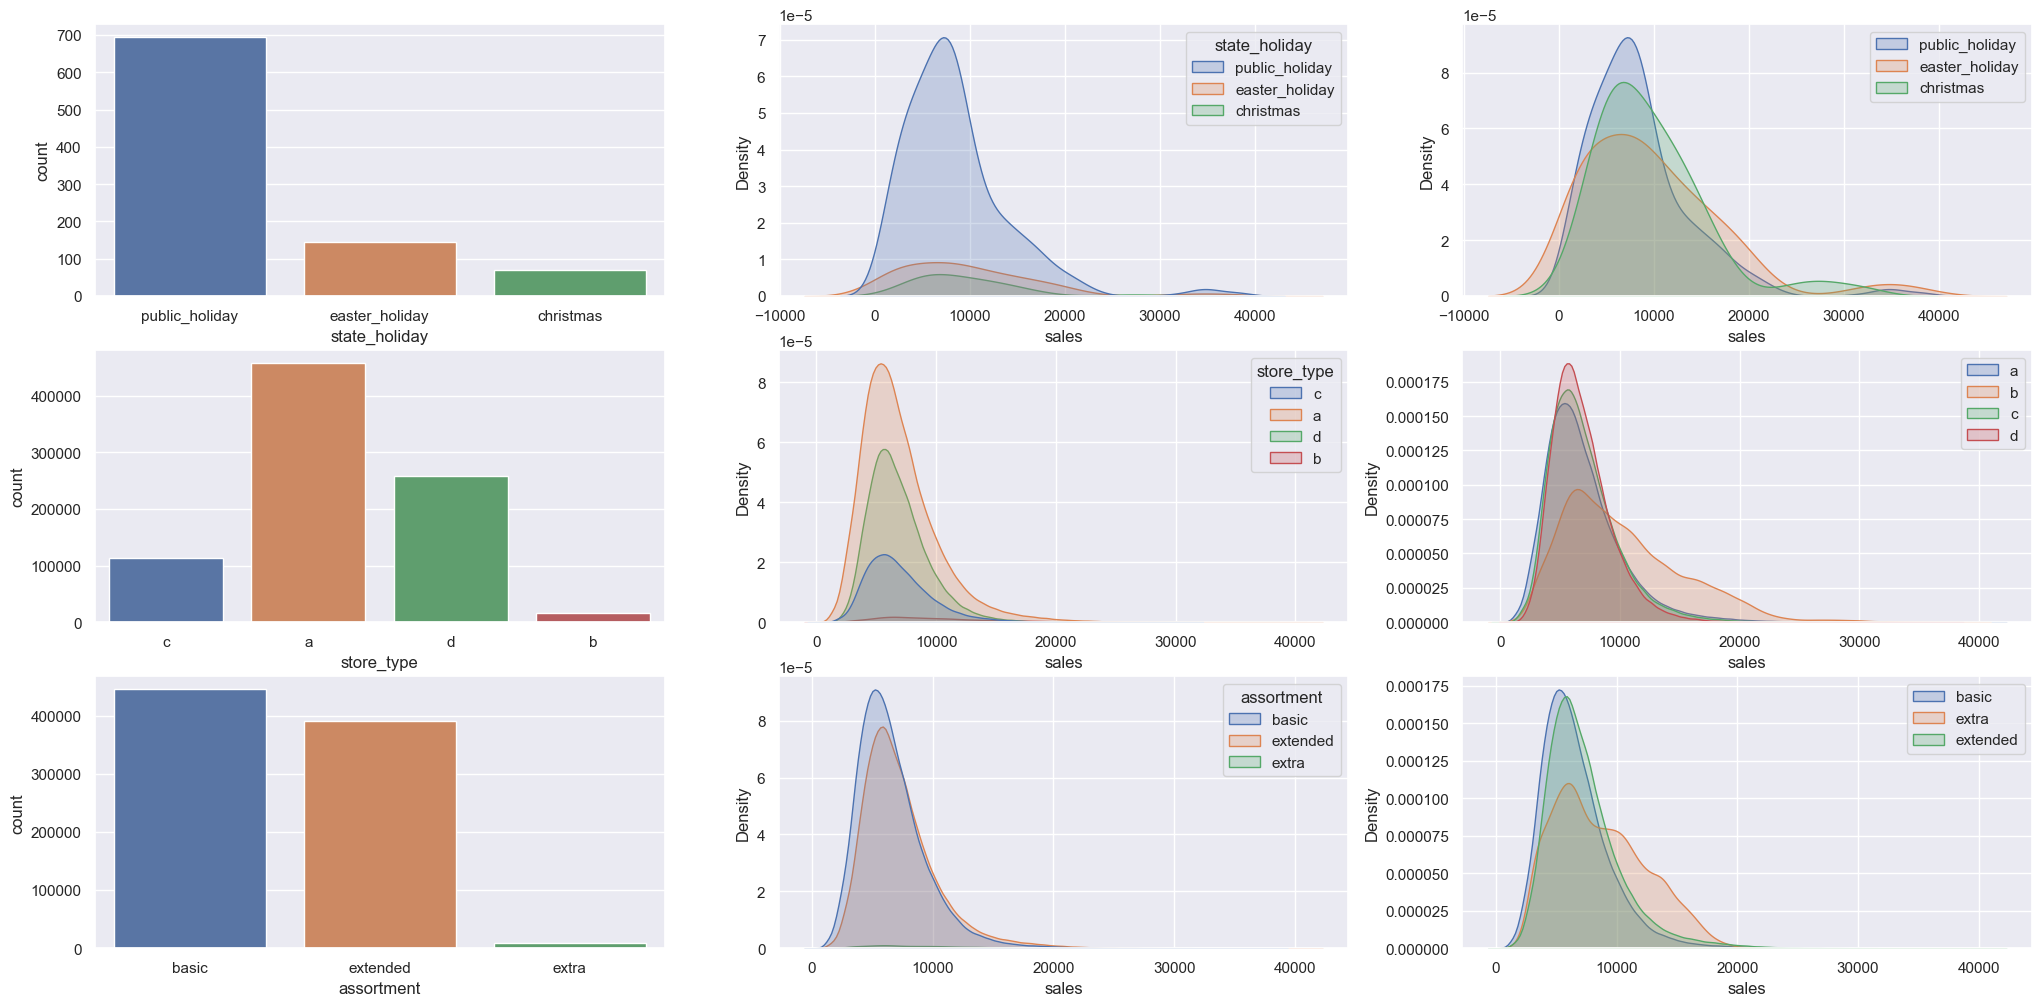

In [37]:
# 'state_holiday'
plt.subplot( 3, 3, 1)
a = df4[ df4[ 'state_holiday' ] != 'regular_day' ]
sns.countplot( x = a['state_holiday'] )

plt.subplot( 3, 3, 2)
sns.kdeplot( df4[ df4[ 'state_holiday' ] != 'regular_day' ], x = 'sales', hue ='state_holiday', fill = True )

plt.subplot( 3, 3, 3)
sns.kdeplot( df4[ df4[ 'state_holiday' ] == 'public_holiday' ]['sales'], label = 'public_holiday', fill = True )
sns.kdeplot( df4[ df4[ 'state_holiday' ] == 'easter_holiday' ]['sales'], label = 'easter_holiday', fill = True )
sns.kdeplot( df4[ df4[ 'state_holiday' ] == 'christmas' ]['sales'], label = 'christmas', fill = True )
plt.legend()

# 'store_type'
plt.subplot( 3, 3, 4)
sns.countplot( x = df4['store_type'] )

plt.subplot( 3, 3, 5)
sns.kdeplot( df4, x = 'sales', hue ='store_type', fill = True )

plt.subplot( 3, 3, 6)
sns.kdeplot( df4[ df4[ 'store_type' ] == 'a' ]['sales'], label = 'a', fill = True )
sns.kdeplot( df4[ df4[ 'store_type' ] == 'b' ]['sales'], label = 'b', fill = True )
sns.kdeplot( df4[ df4[ 'store_type' ] == 'c' ]['sales'], label = 'c', fill = True )
sns.kdeplot( df4[ df4[ 'store_type' ] == 'd' ]['sales'], label = 'd', fill = True )
plt.legend()

# 'assortment'
plt.subplot( 3, 3, 7)
sns.countplot( x = df4['assortment'] )

plt.subplot( 3, 3, 8)
sns.kdeplot( df4, x = 'sales', hue ='assortment', fill = True )

plt.subplot( 3, 3, 9)
sns.kdeplot( df4[ df4[ 'assortment' ] == 'basic' ]['sales'], label = 'basic', fill = True )
sns.kdeplot( df4[ df4[ 'assortment' ] == 'extra' ]['sales'], label = 'extra', fill = True )
sns.kdeplot( df4[ df4[ 'assortment' ] == 'extended' ]['sales'], label = 'extended', fill = True )
plt.legend()


## 4.2 - Análise Bivariada

### **H1.** Lojas com maior sortimentos deveriam vender mais.
**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS.

<Axes: xlabel='year_week'>

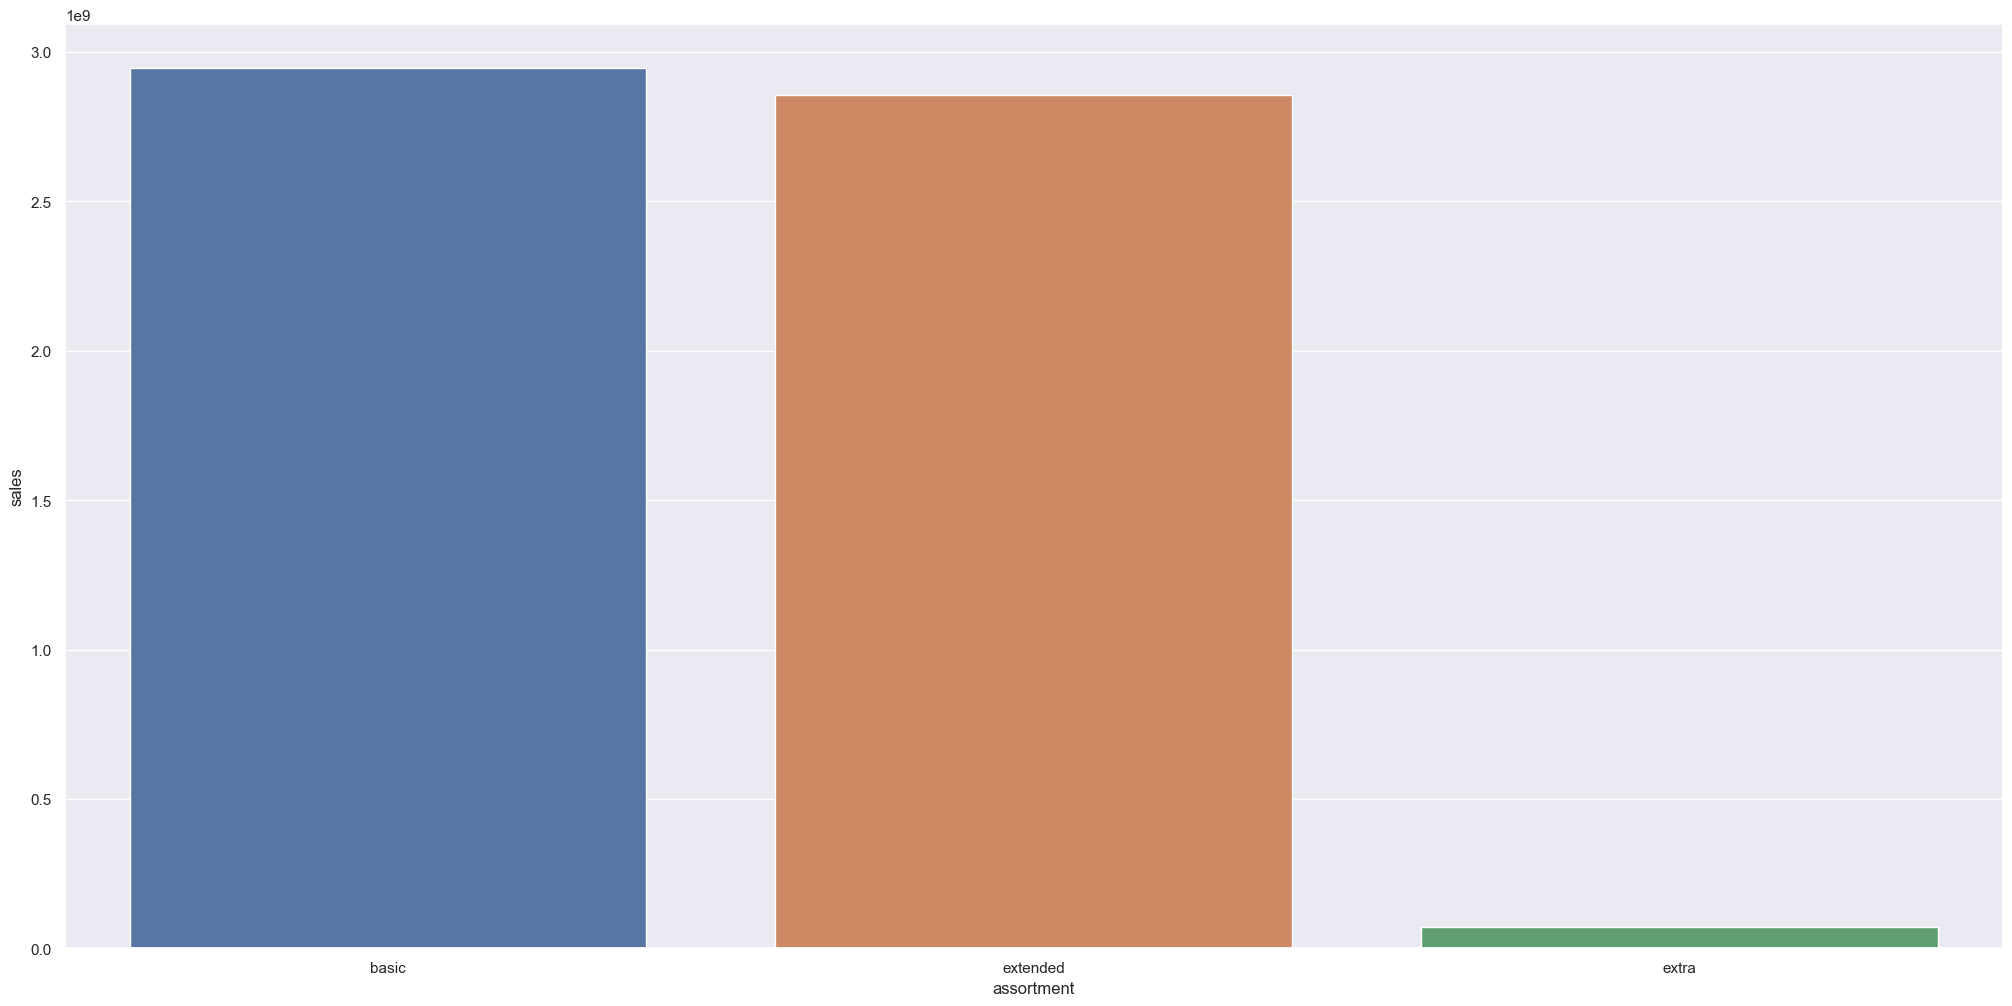

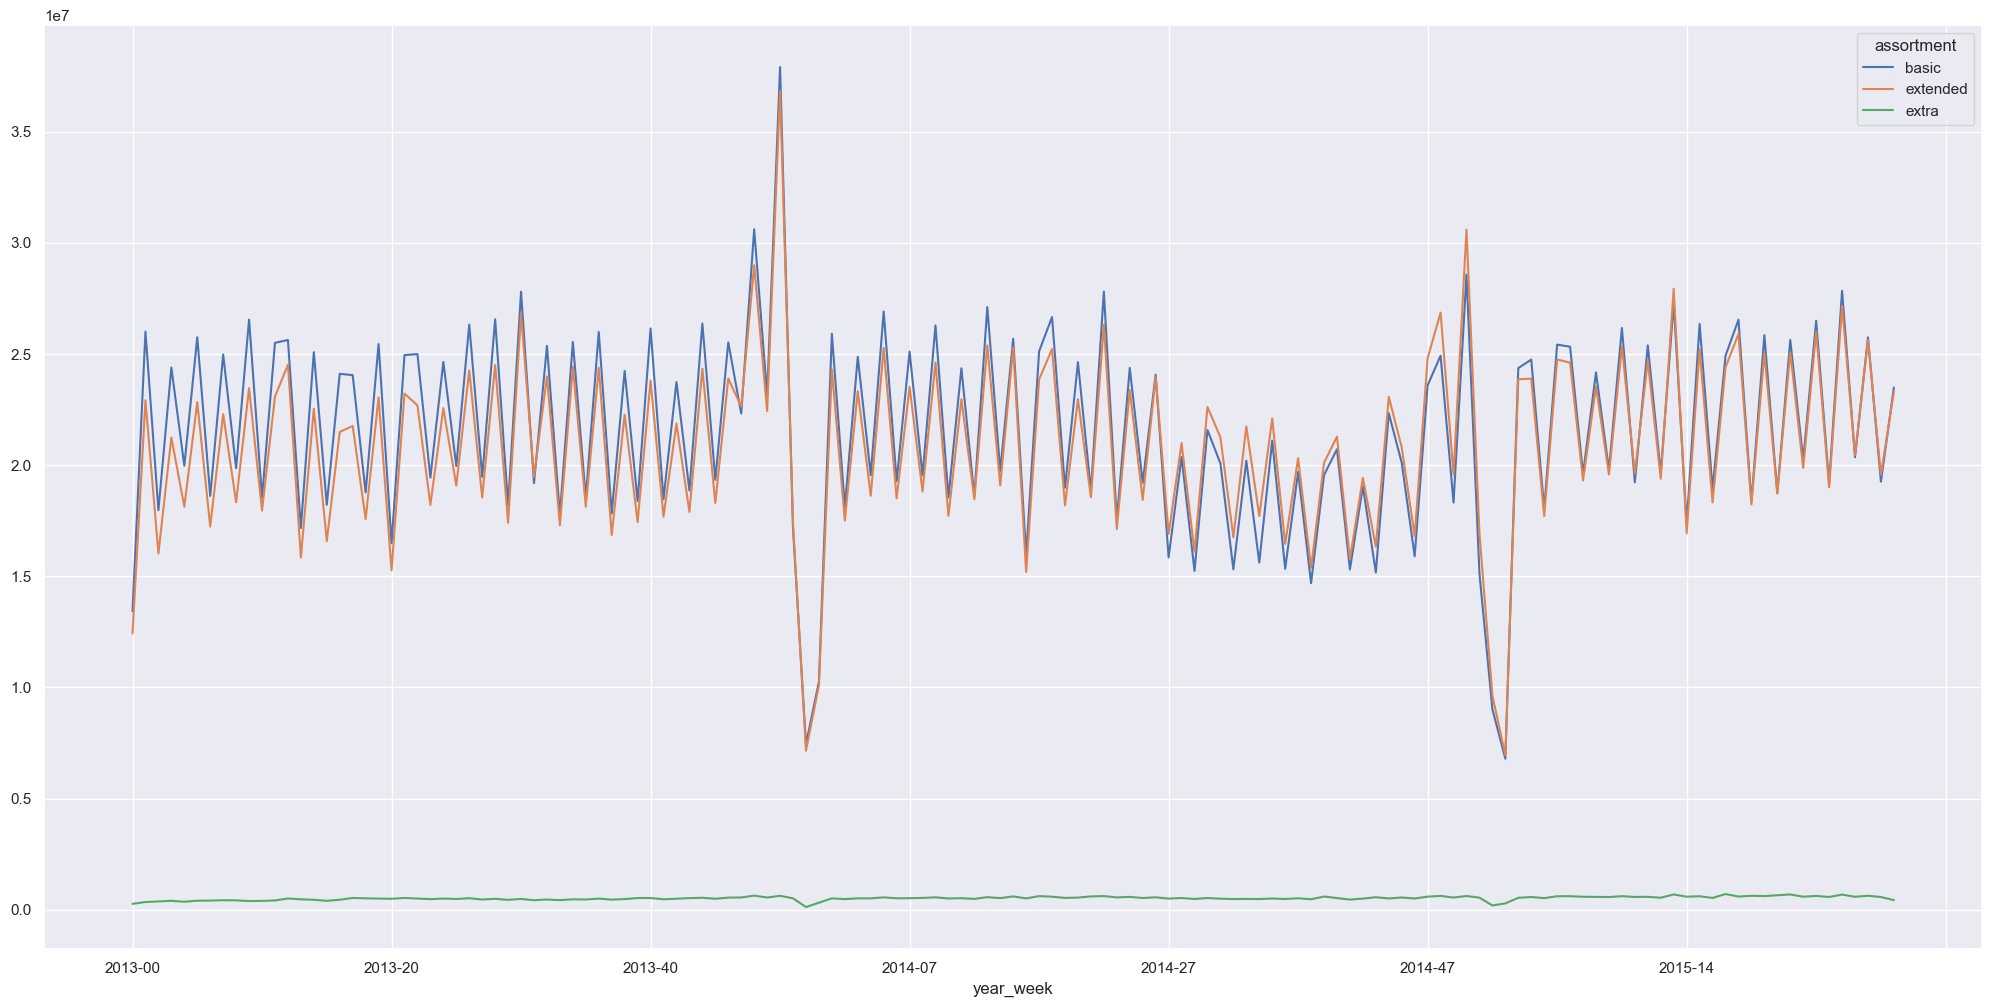

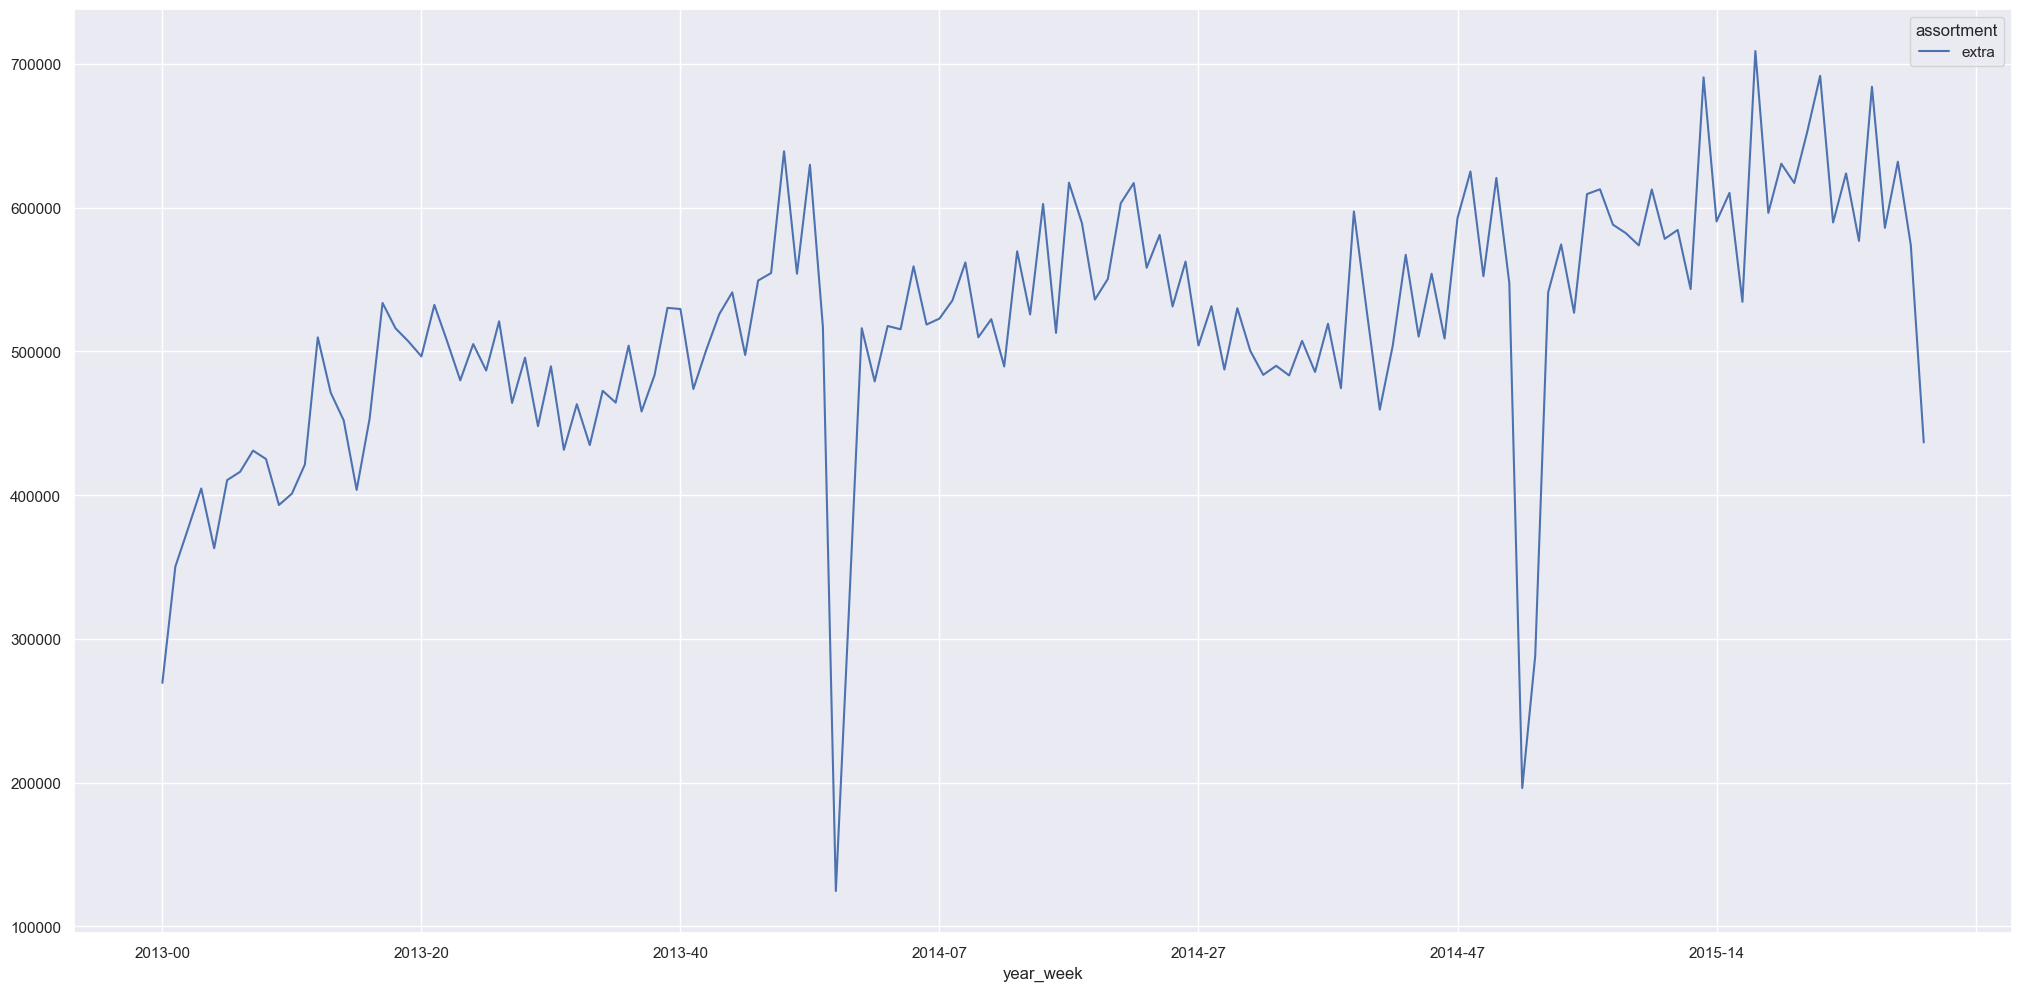

In [38]:
aux1 = df4[ [ 'assortment', 'sales' ] ].groupby( 'assortment' ).sum().reset_index()
sns.barplot(data = aux1, x = 'assortment', y = 'sales');

aux2 = df4[ [ 'year_week', 'assortment', 'sales' ] ].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux2.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot()

aux3 = aux2[ aux2['assortment'] == 'extra' ]
aux3.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot()

### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com COMPETIDORES MAIS PROXIMOS vendes MAIS.

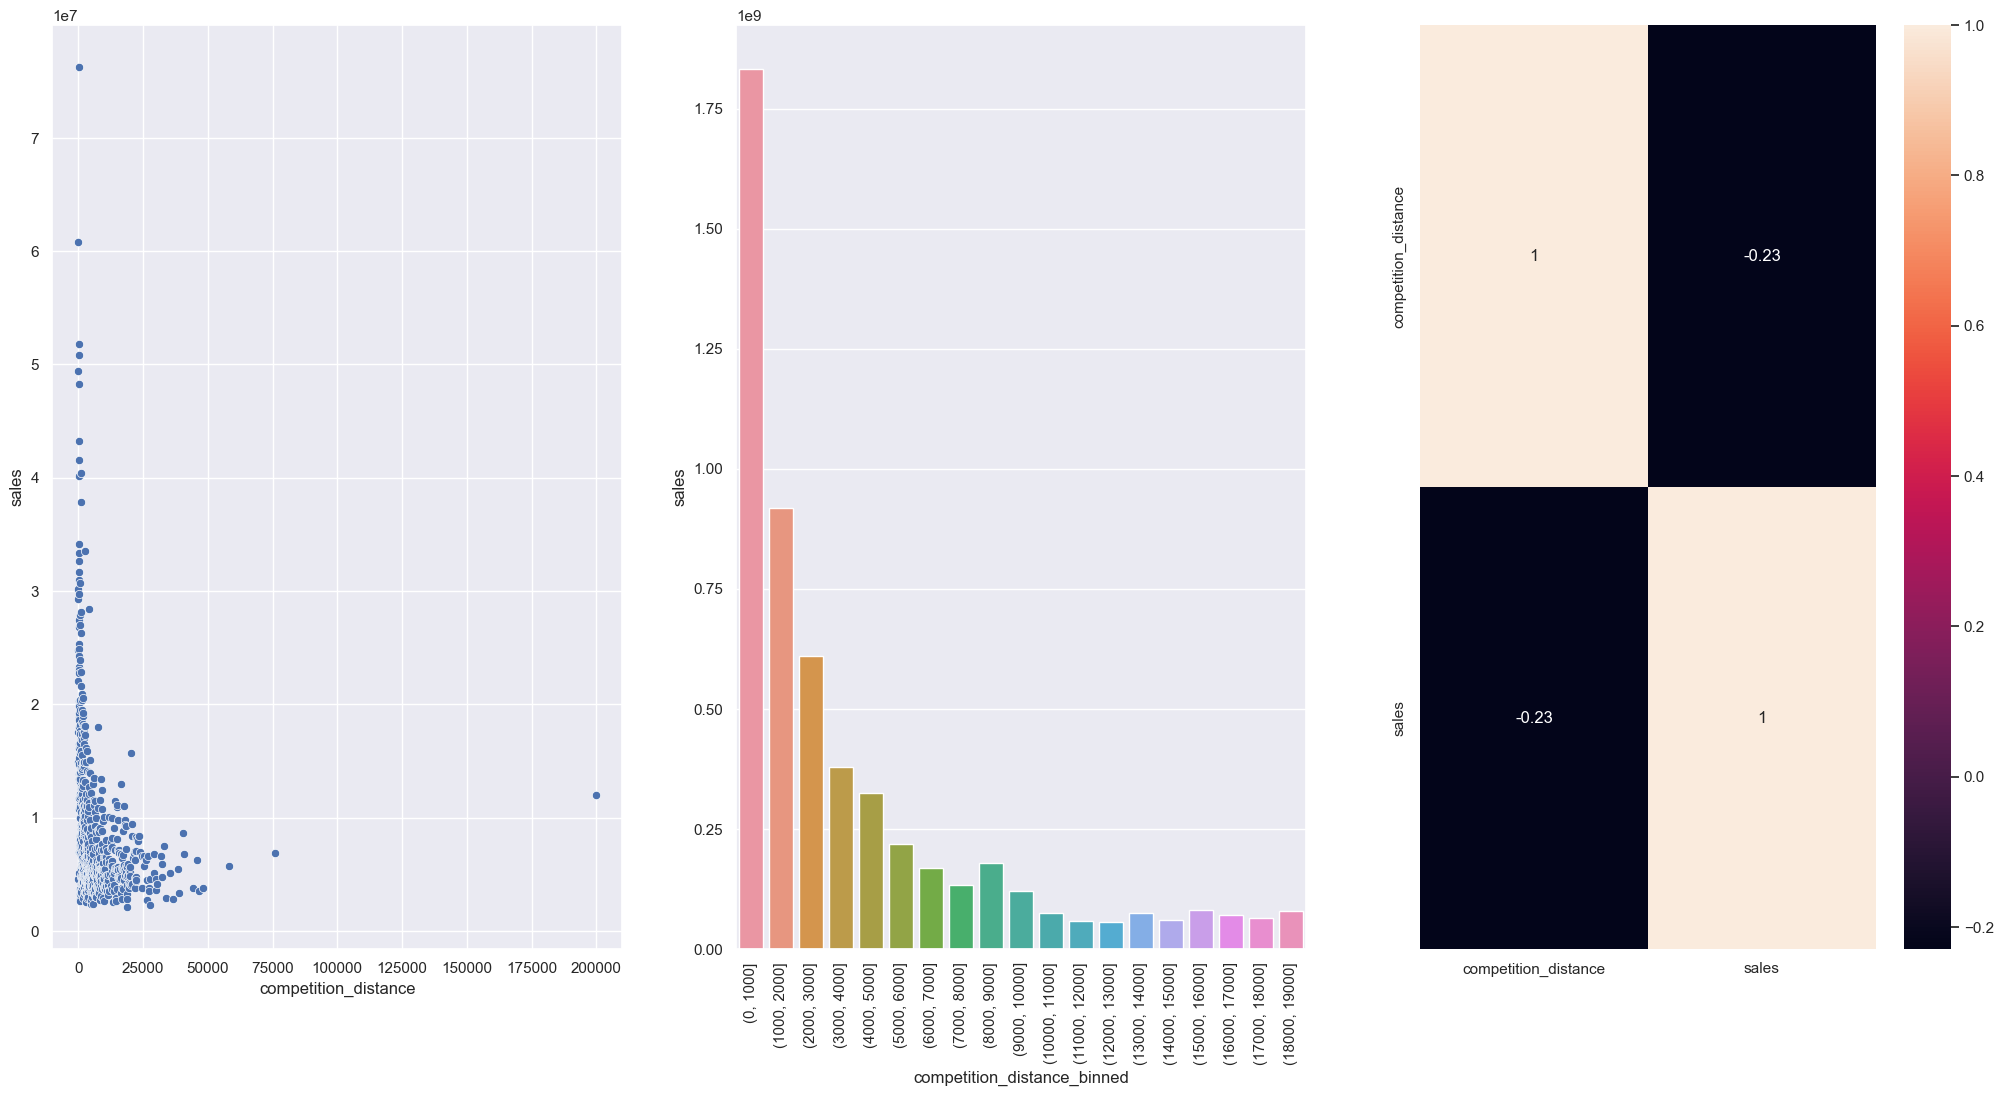

In [39]:
plt.subplot( 1, 3, 1 )
aux4 = df4[ ['competition_distance', 'sales'] ].groupby('competition_distance').sum().reset_index()
sns.scatterplot(data = aux4, x = 'competition_distance', y = 'sales');

plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000 ))
aux4['competition_distance_binned'] = pd.cut( aux4['competition_distance'], bins = bins)
aux5 = aux4[ [ 'competition_distance_binned', 'sales' ] ].groupby(['competition_distance_binned']).sum().reset_index()
sns.barplot(data = aux5, x = 'competition_distance_binned', y = 'sales')
plt.xticks( rotation = 90 )

plt.subplot ( 1, 3, 3 )
sns.heatmap( aux4[ [ 'competition_distance', 'sales' ] ].corr( method = 'pearson'), annot = True );
# x = sns.heatmap( aux4[ [ 'competition_distance', 'sales' ] ].corr( method = 'pearson'), annot = True );
# bottom, top = x.get_Ylim()
# x.set_ylim( bottom+0.5, top-0.5 );


### **H3.** Lojas com competidores à mais tempo deveriam vender mais.
**FALSA** Lojas com competidores a MAIS tempo vendem MENOS.


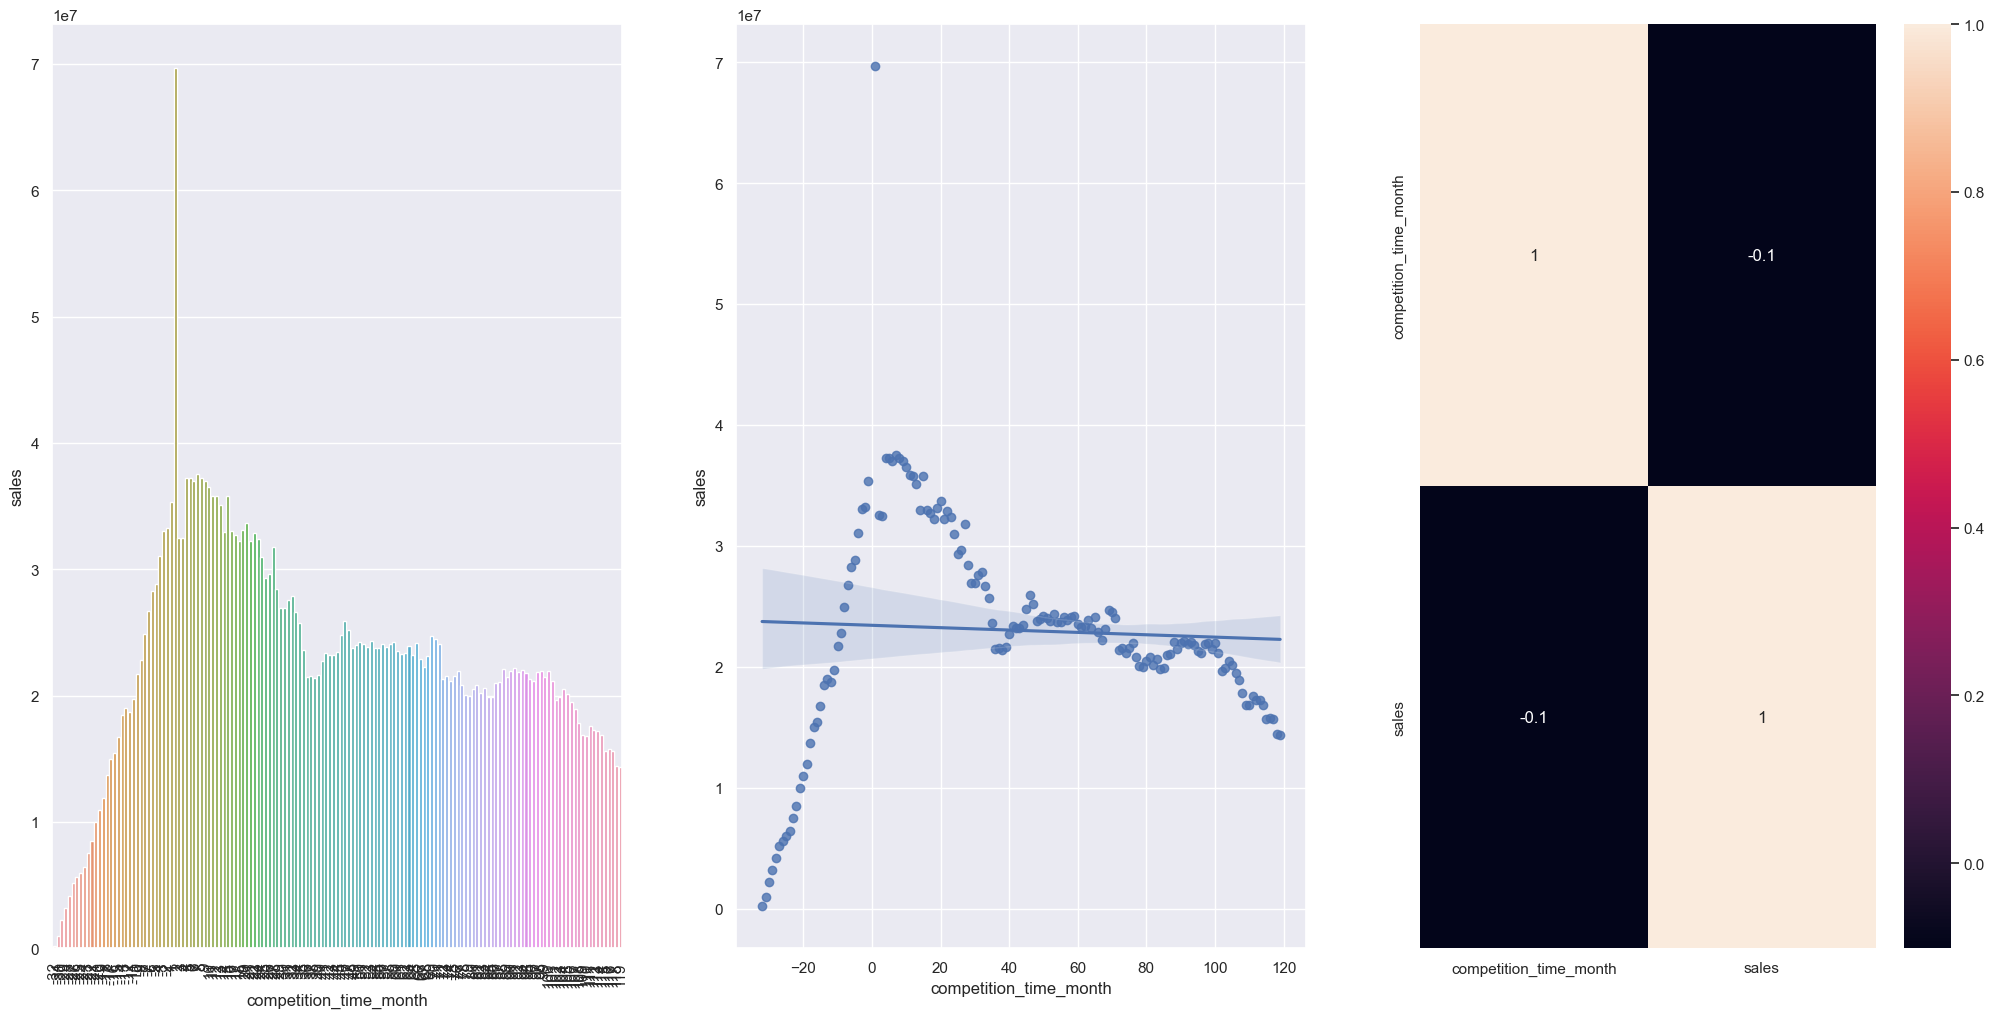

In [40]:
aux1 = df4[['competition_time_month', 'sales' ]].groupby(['competition_time_month']).sum().reset_index()
aux2 = aux1[ ( aux1[ 'competition_time_month' ] < 120 ) & ( aux1[ 'competition_time_month' ] != 0 ) ]

plt.subplot(1, 3, 1)
sns.barplot(data = aux2, x = 'competition_time_month', y = 'sales');
plt.xticks( rotation = 90 )

plt.subplot(1, 3, 2)
sns.regplot(data = aux2, x = 'competition_time_month', y = 'sales');

plt.subplot(1, 3, 3)
sns.heatmap( aux1[ [ 'competition_time_month', 'sales' ] ].corr( method = 'pearson'), annot = True );
# x = sns.heatmap( aux1[ [ 'competition_time_month', 'sales' ] ].corr( method = 'pearson'), annot = True );
# bottom, top = x.get_ylim()
# x.set_ylim( bottom+0.5, top-0.5 );


### **H4**. Lojas com promoções ativas por mais tempo deveriam vender mais
**FALSA** Lojas com promocoes ativas por MAIS tempo vendem MENOS, depois de um certo periodo de promocao.

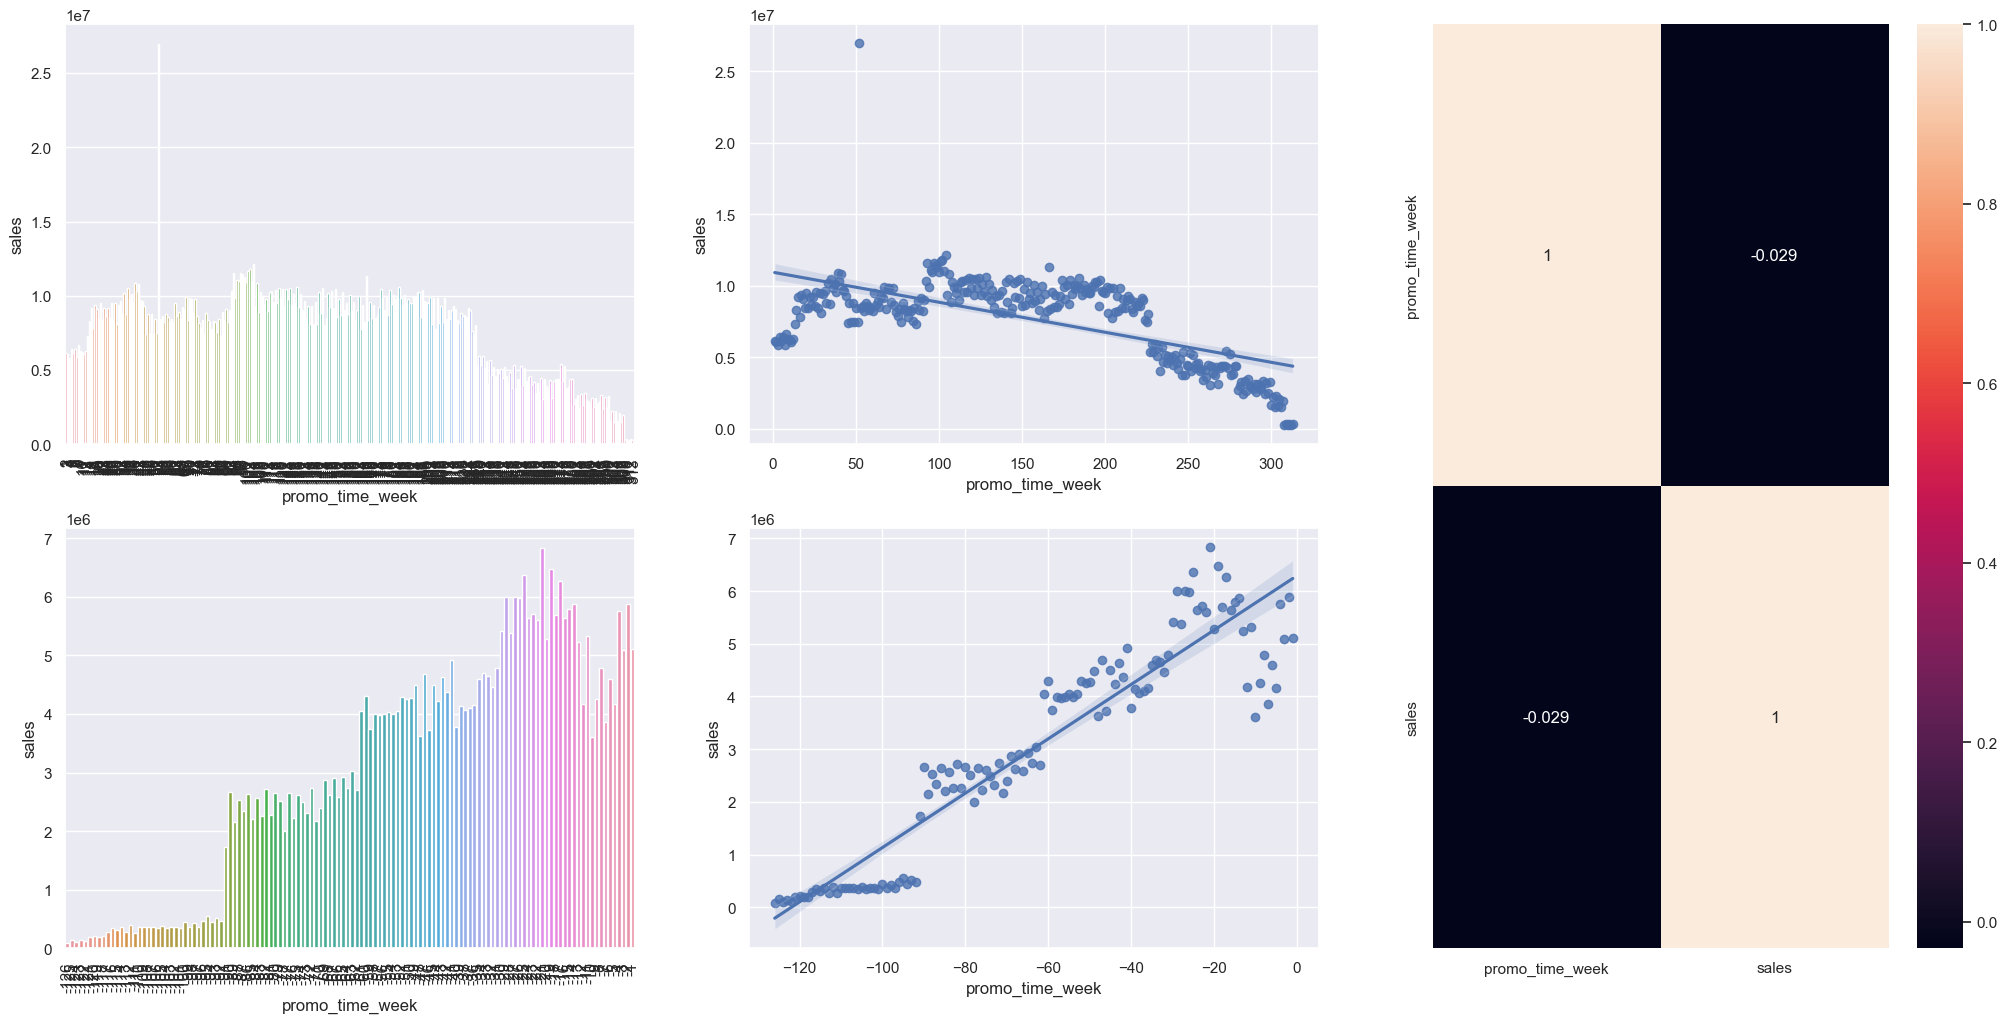

In [41]:
grid = GridSpec(2, 3)

aux1 = df4[ [ 'promo_time_week', 'sales' ] ].groupby( [ 'promo_time_week' ] ).sum().reset_index()
aux2 = aux1[ aux1[ 'promo_time_week' ] > 0 ] # promo extendida
aux3 = aux1[ aux1[ 'promo_time_week' ] < 0 ] # promo regular

plt.subplot( grid[ 0, 0 ] )
sns.barplot( data = aux2, x = 'promo_time_week', y = 'sales' );
plt.xticks( rotation = 90 )

plt.subplot( grid[ 0, 1 ] )
sns.regplot( data = aux2, x = 'promo_time_week', y = 'sales' );


plt.subplot( grid[ 1, 0 ] )
sns.barplot( data = aux3, x = 'promo_time_week', y = 'sales' );
plt.xticks( rotation = 90 )

plt.subplot( grid[ 1, 1 ] )
sns.regplot( data = aux3, x = 'promo_time_week', y = 'sales' );

plt.subplot( grid[ :, 2 ] )
sns.heatmap( aux1.corr( method = 'pearson' ), annot = True );


### <s>**H5**. Lojas com mais dias de promoção deveriam vender mais.</s>


### **H6**. Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com MAIS promocoes consecutivas vendem MENOS.

In [42]:
df4[ [ 'promo', 'promo2', 'sales' ] ].groupby( [ 'promo', 'promo2' ] ).sum().reset_index().sort_values('sales')

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


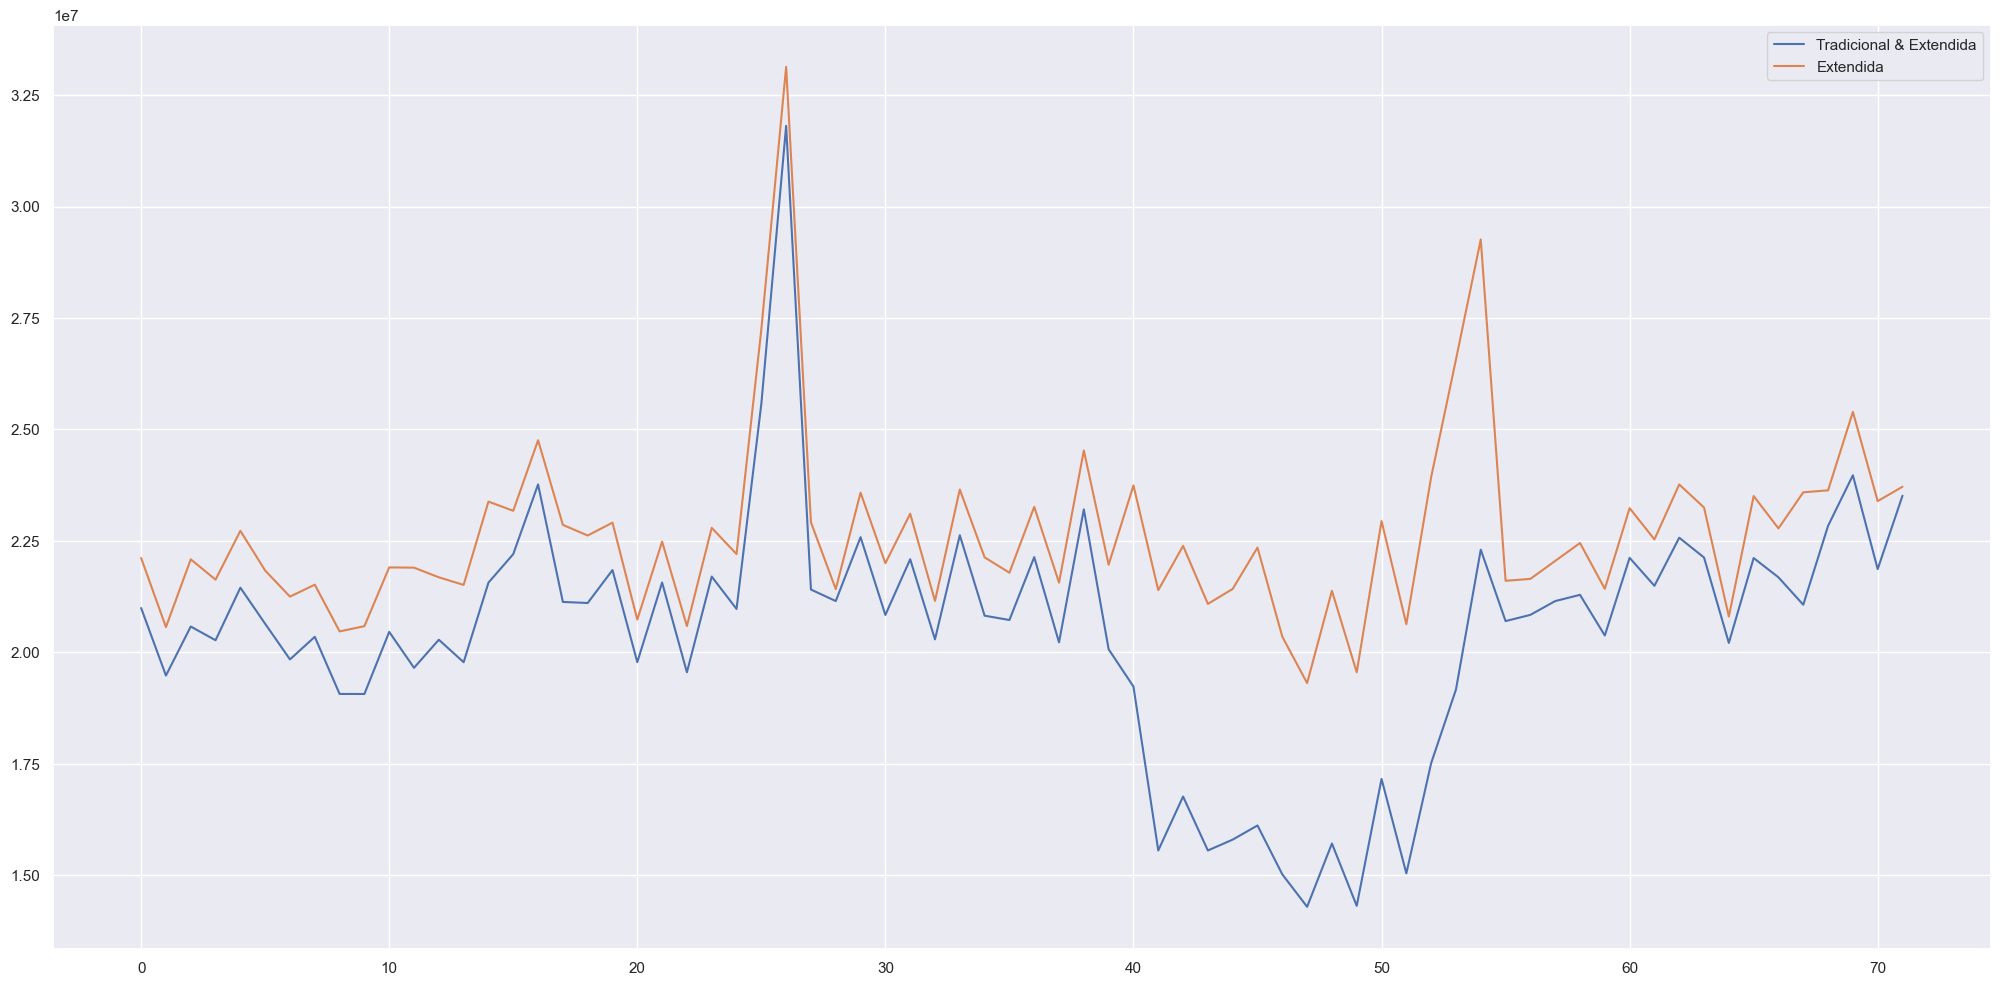

In [43]:
aux1 = df4[ ( df4[ 'promo'] == 1 ) & ( df4[ 'promo2'] == 1 ) ][ [ 'year_week', 'sales' ] ].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[ ( df4[ 'promo'] == 1 ) & ( df4[ 'promo2'] == 0 ) ][ [ 'year_week', 'sales' ] ].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax = ax );

ax.legend( labels = [ 'Tradicional & Extendida',  'Extendida' ] );

### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas abertas durante o feriado do Natal vendem menos.

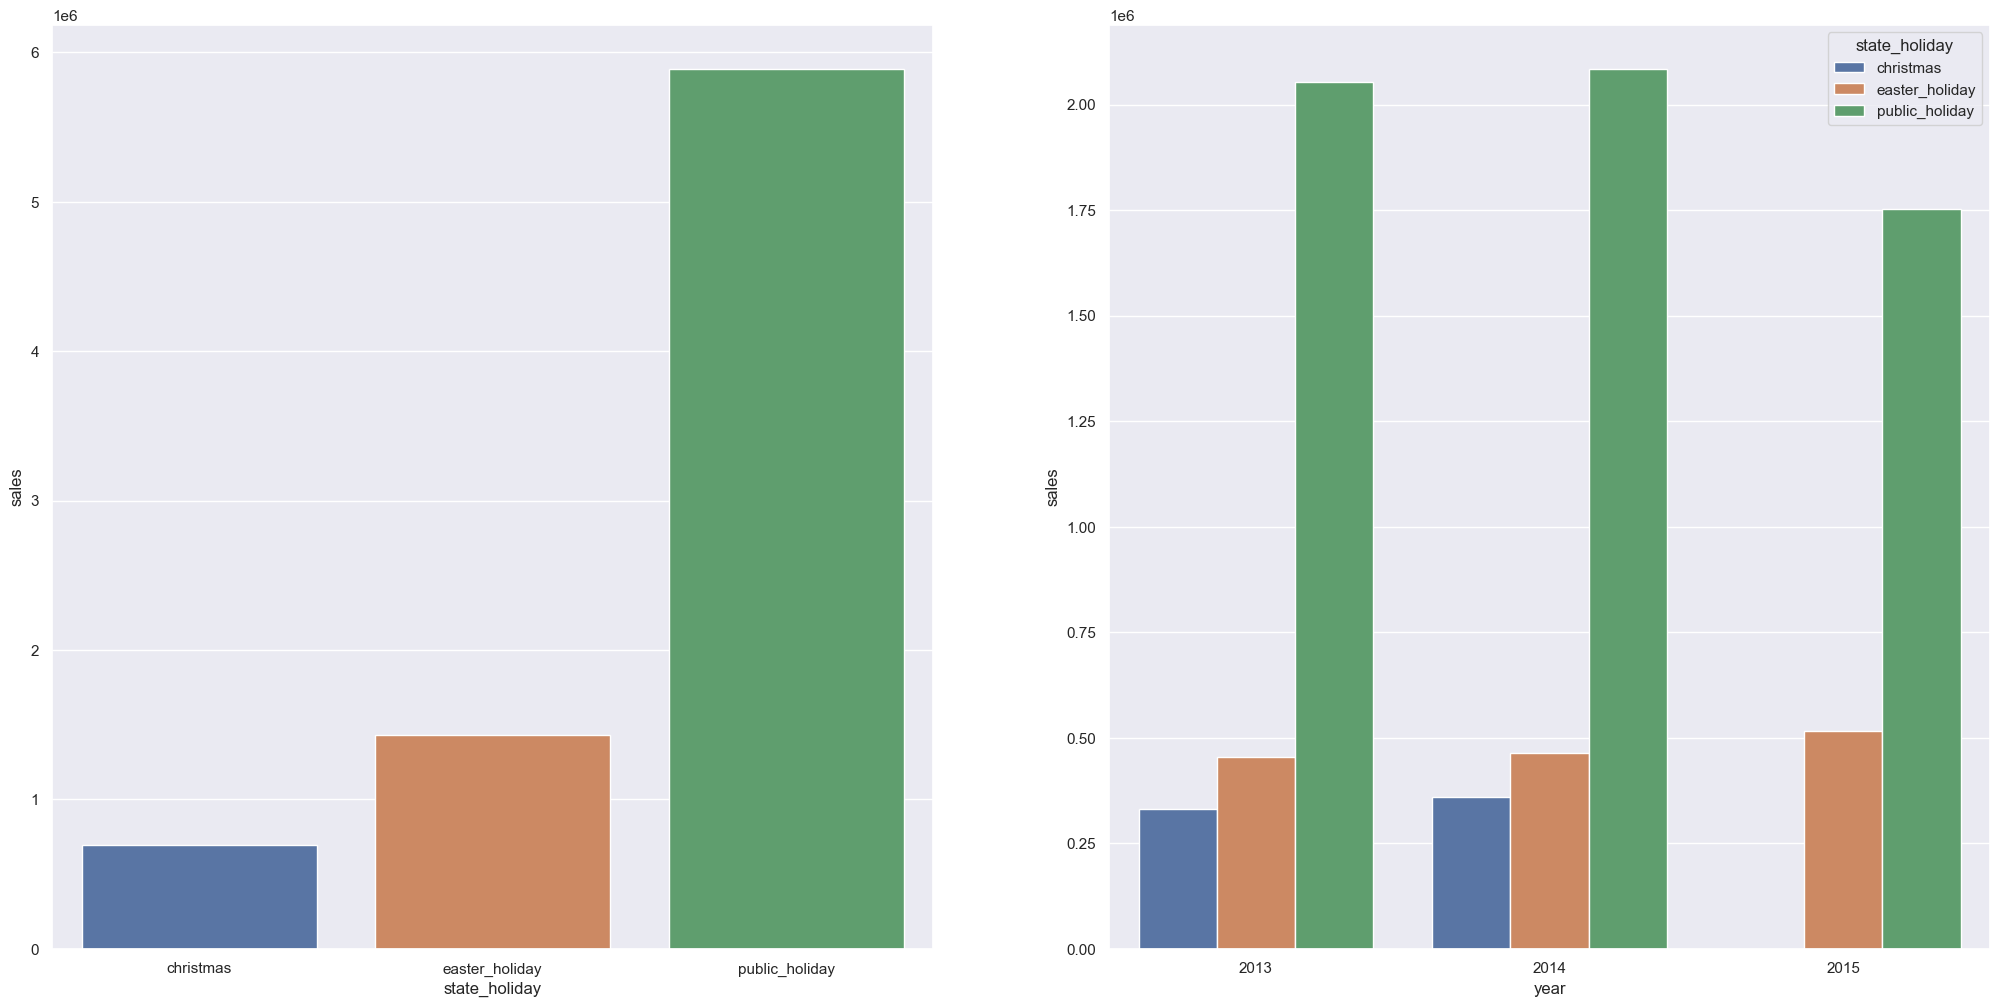

In [44]:
aux1 = df4[df4['state_holiday'] != 'regular_day']
aux2 = aux1[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
aux3 = aux1[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()

subplot(1, 2, 1)
sns.barplot(data = aux2, x = 'state_holiday', y = 'sales');

subplot(1, 2, 2)
sns.barplot(data = aux3, x = 'year', y = 'sales', hue = 'state_holiday');

### **H8.** Lojas deveriam vender mais ao longo dos anos.
**FALSA** LOjas vendem MENOS ao longo dos anos.

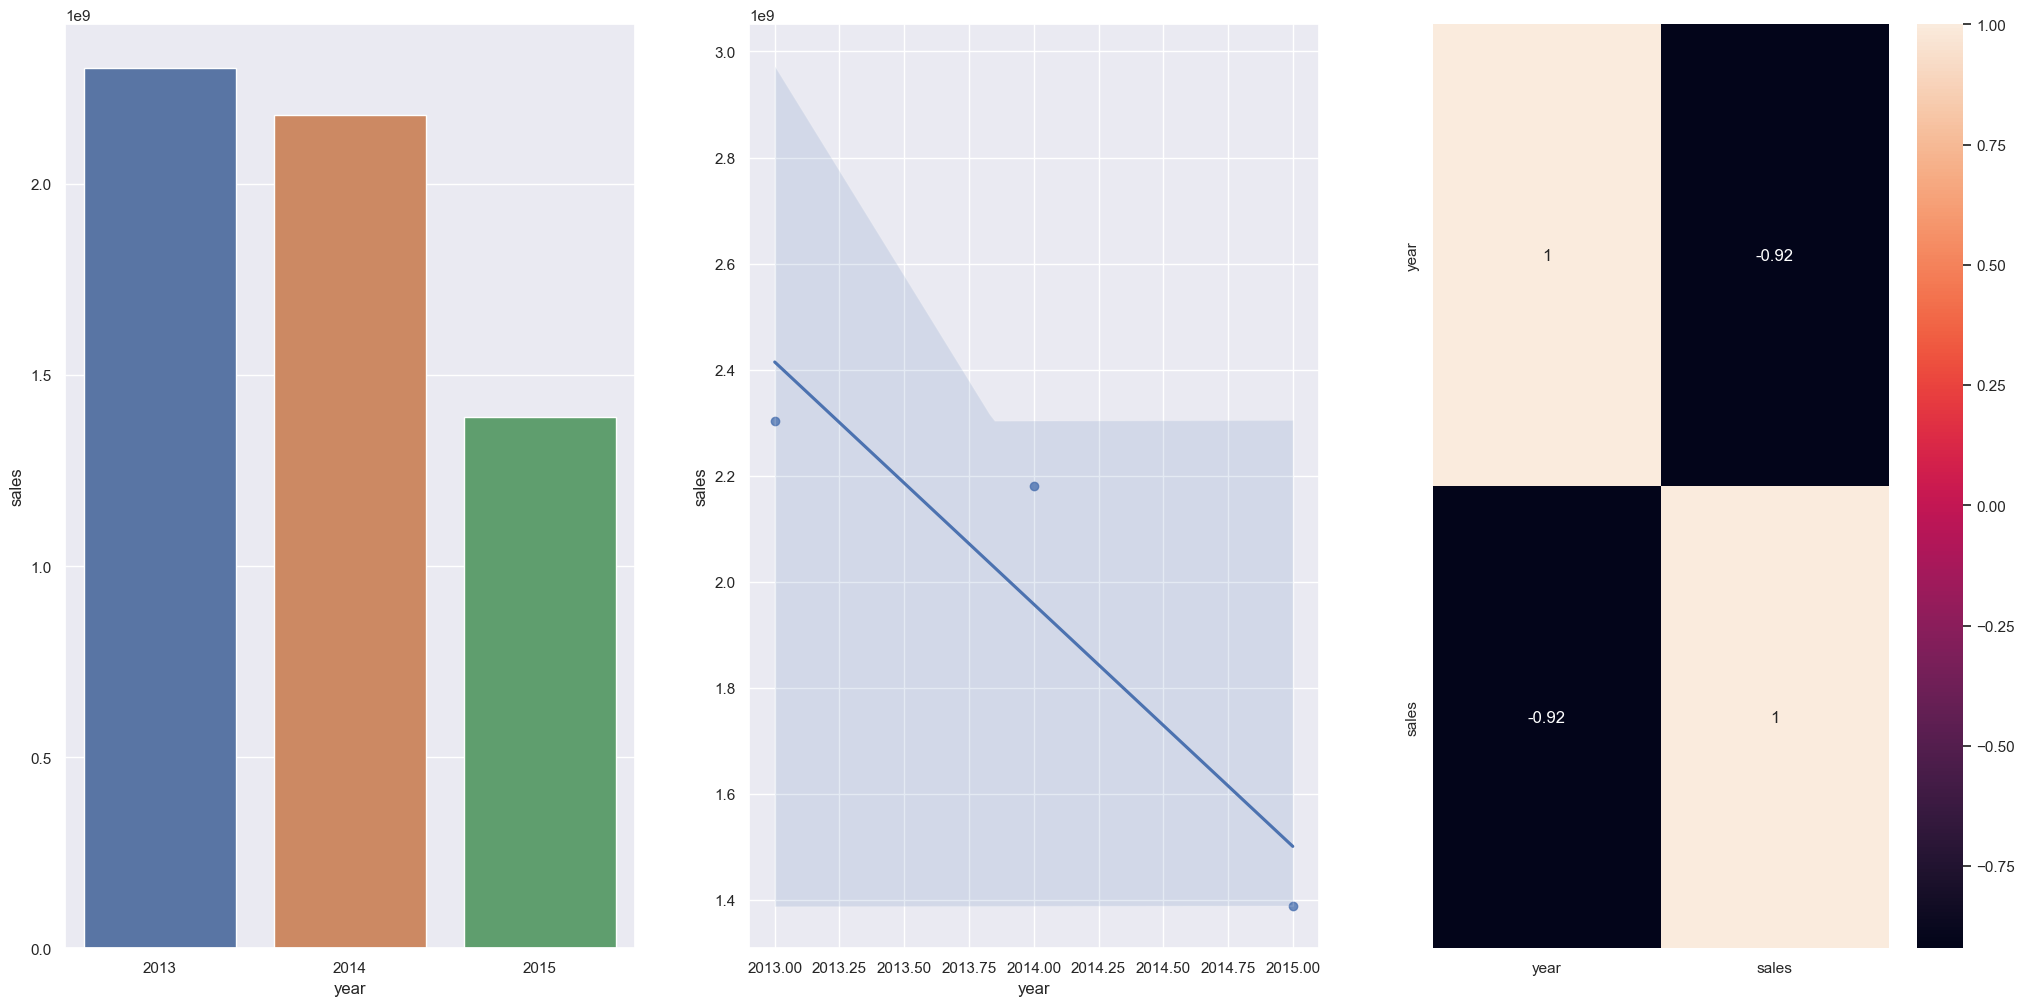

In [47]:
aux1 = df4[ [ 'year', 'sales' ] ].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(data = aux1, x = 'year', y = 'sales');

plt.subplot(1, 3, 2)
sns.regplot(data = aux1, x = 'year', y = 'sales');

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method='pearson'), annot = True);

### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** Lojas vendem MENOS no segundo semestre do ano.

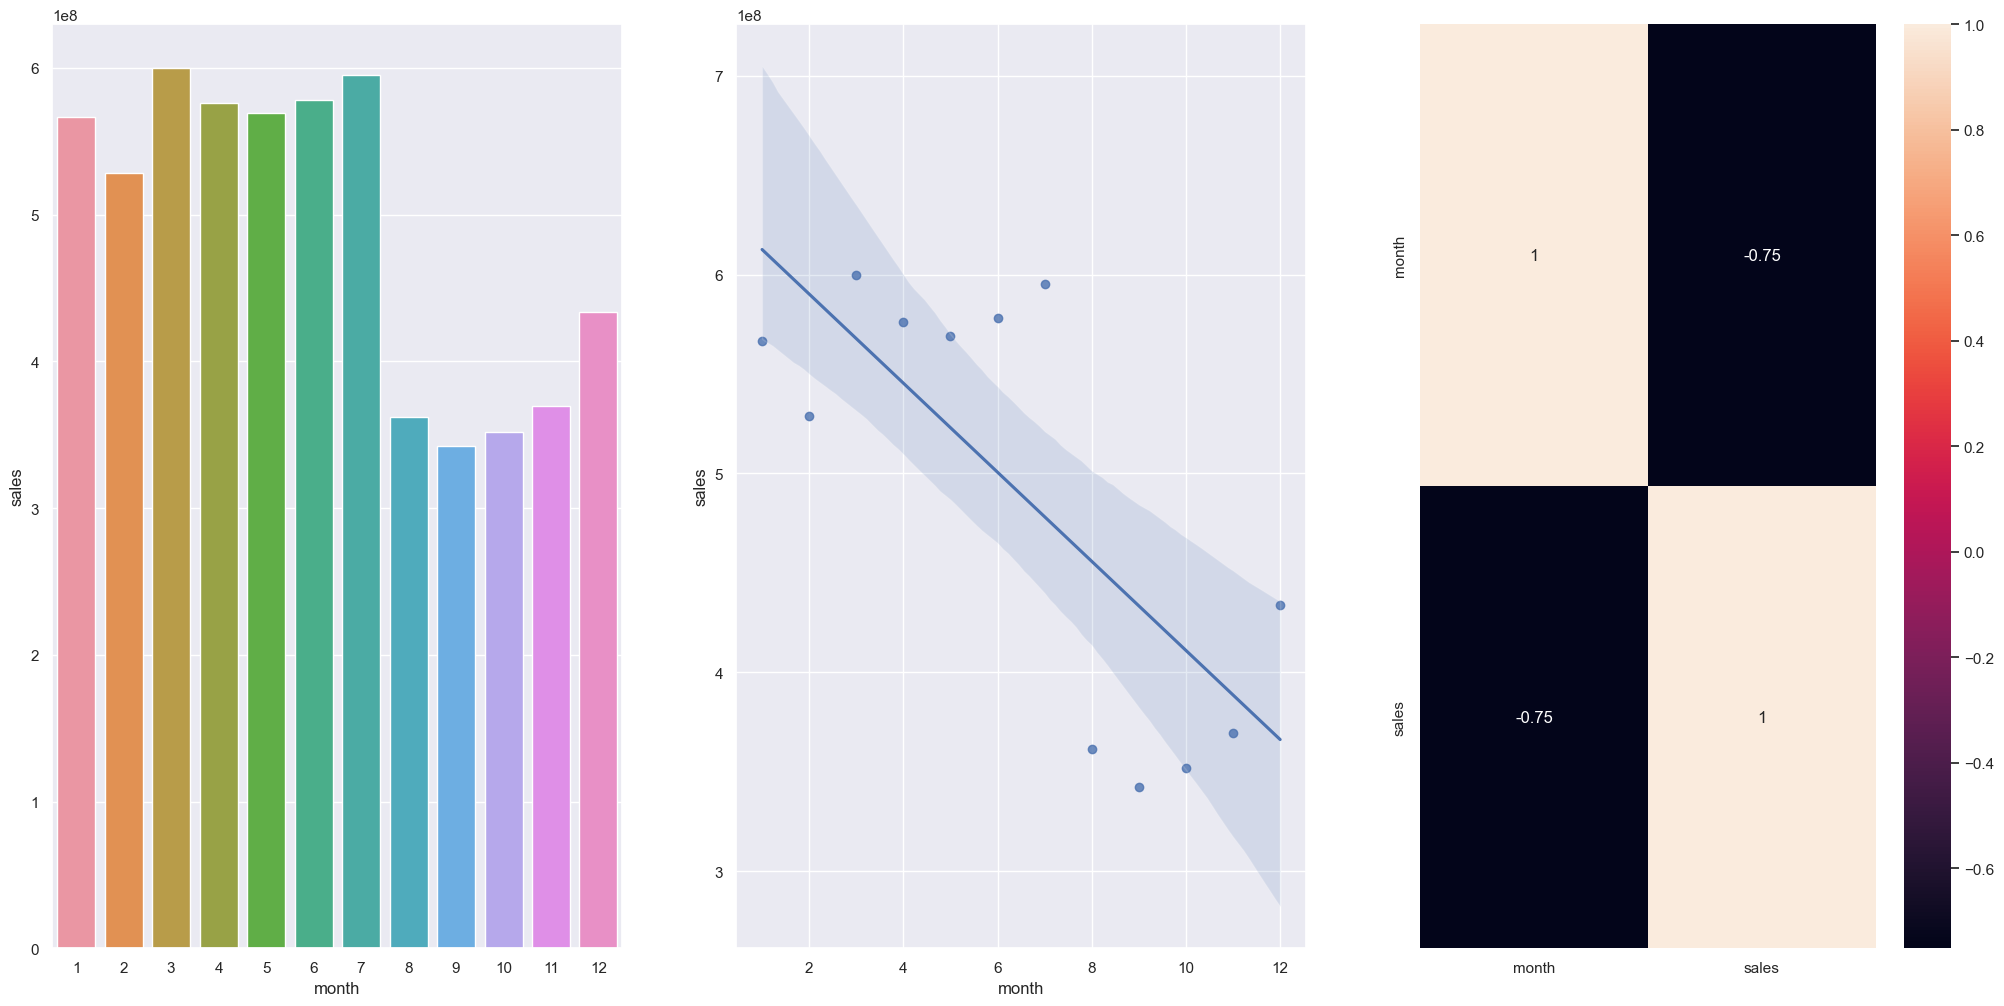

In [56]:
aux1 = df4[ [ 'month', 'sales' ] ].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(data = aux1, x = 'month', y = 'sales');

plt.subplot(1, 3, 2)
sns.regplot(data = aux1, x = 'month', y = 'sales');

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method='pearson'), annot = True);

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mês.

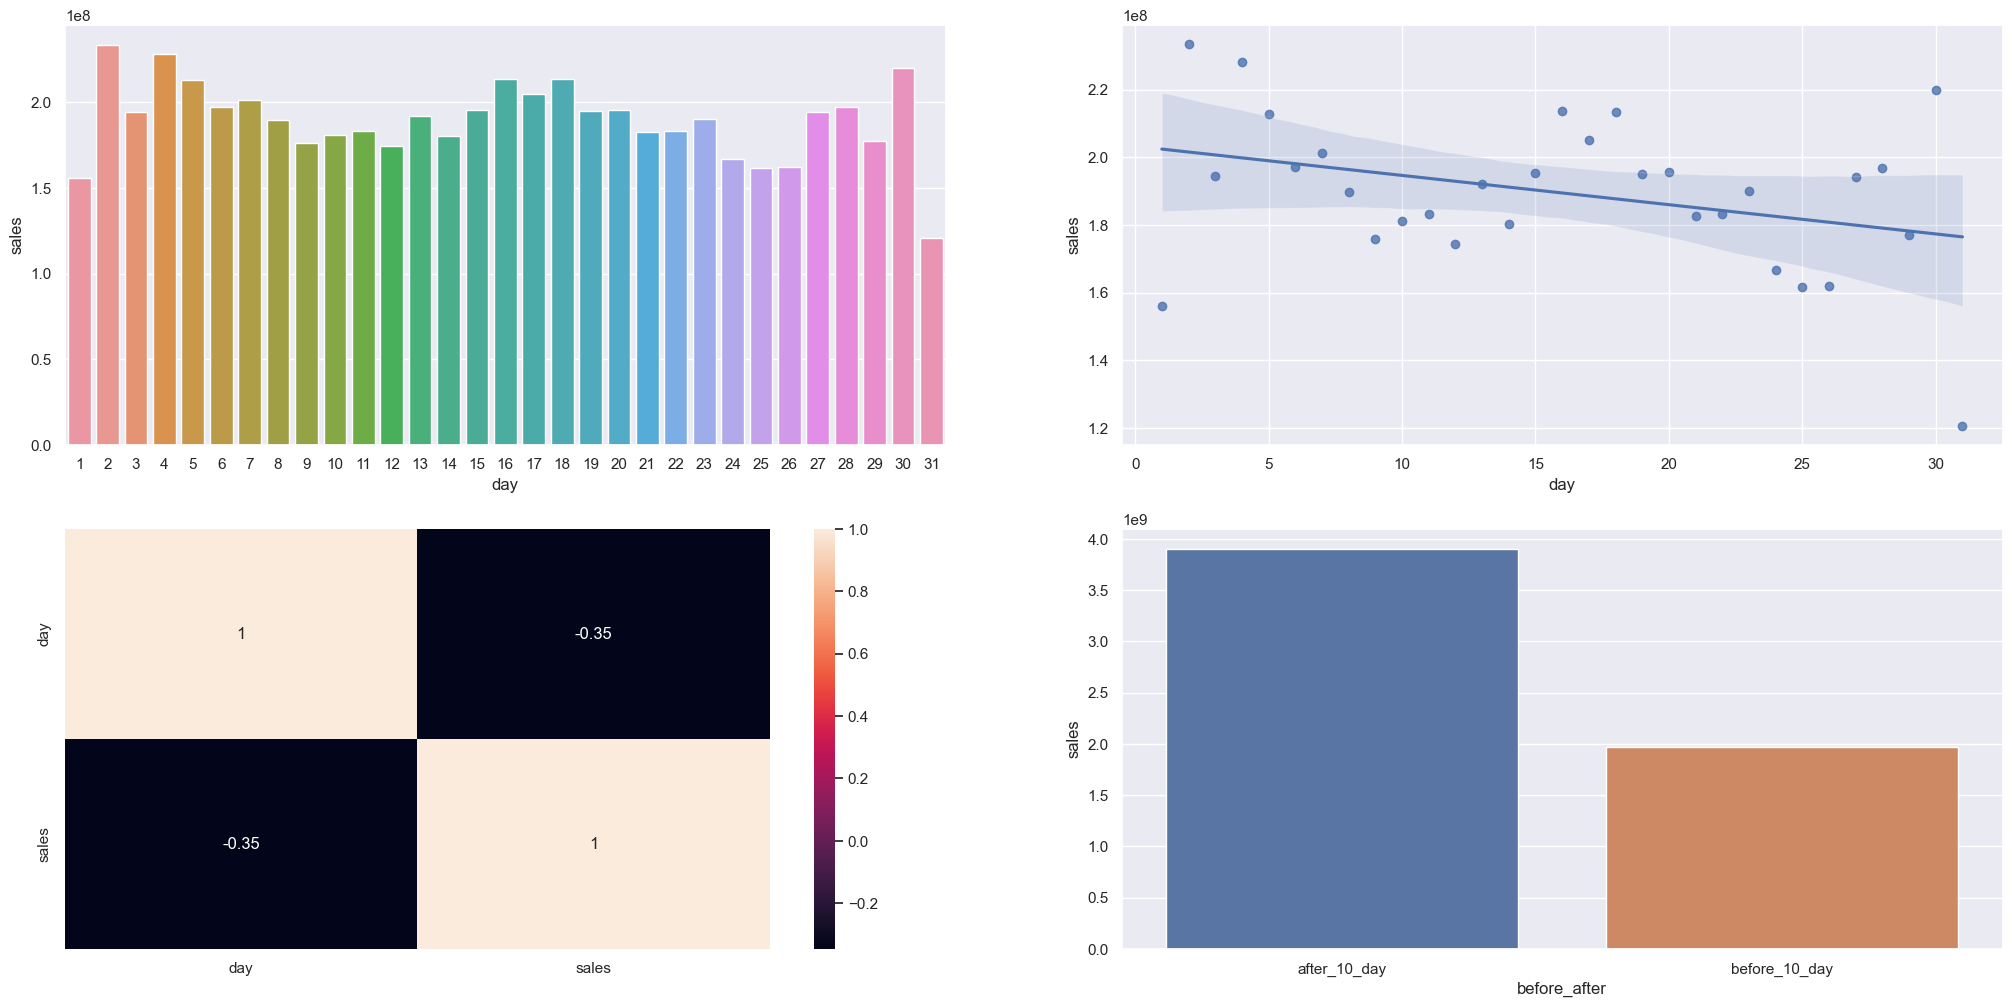

In [90]:
aux1 = df4[ [ 'day', 'sales' ] ].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(data = aux1, x = 'day', y = 'sales');

plt.subplot(2, 2, 2)
sns.regplot(data = aux1, x = 'day', y = 'sales');

plt.subplot(2, 2, 3)
sns.heatmap( aux1.corr( method='pearson'), annot = True);

aux1['before_after'] = aux1[ 'day' ].apply( lambda x: 'before_10_day' if x <= 10 else 'after_10_day')
aux2 = aux1[ [ 'before_after', 'sales' ] ].groupby('before_after').sum().reset_index()

plt.subplot(2, 2, 4)
sns.barplot(data = aux2, x = 'before_after', y = 'sales');

### **H11.** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** Lojas vendem menos nos final de semana.

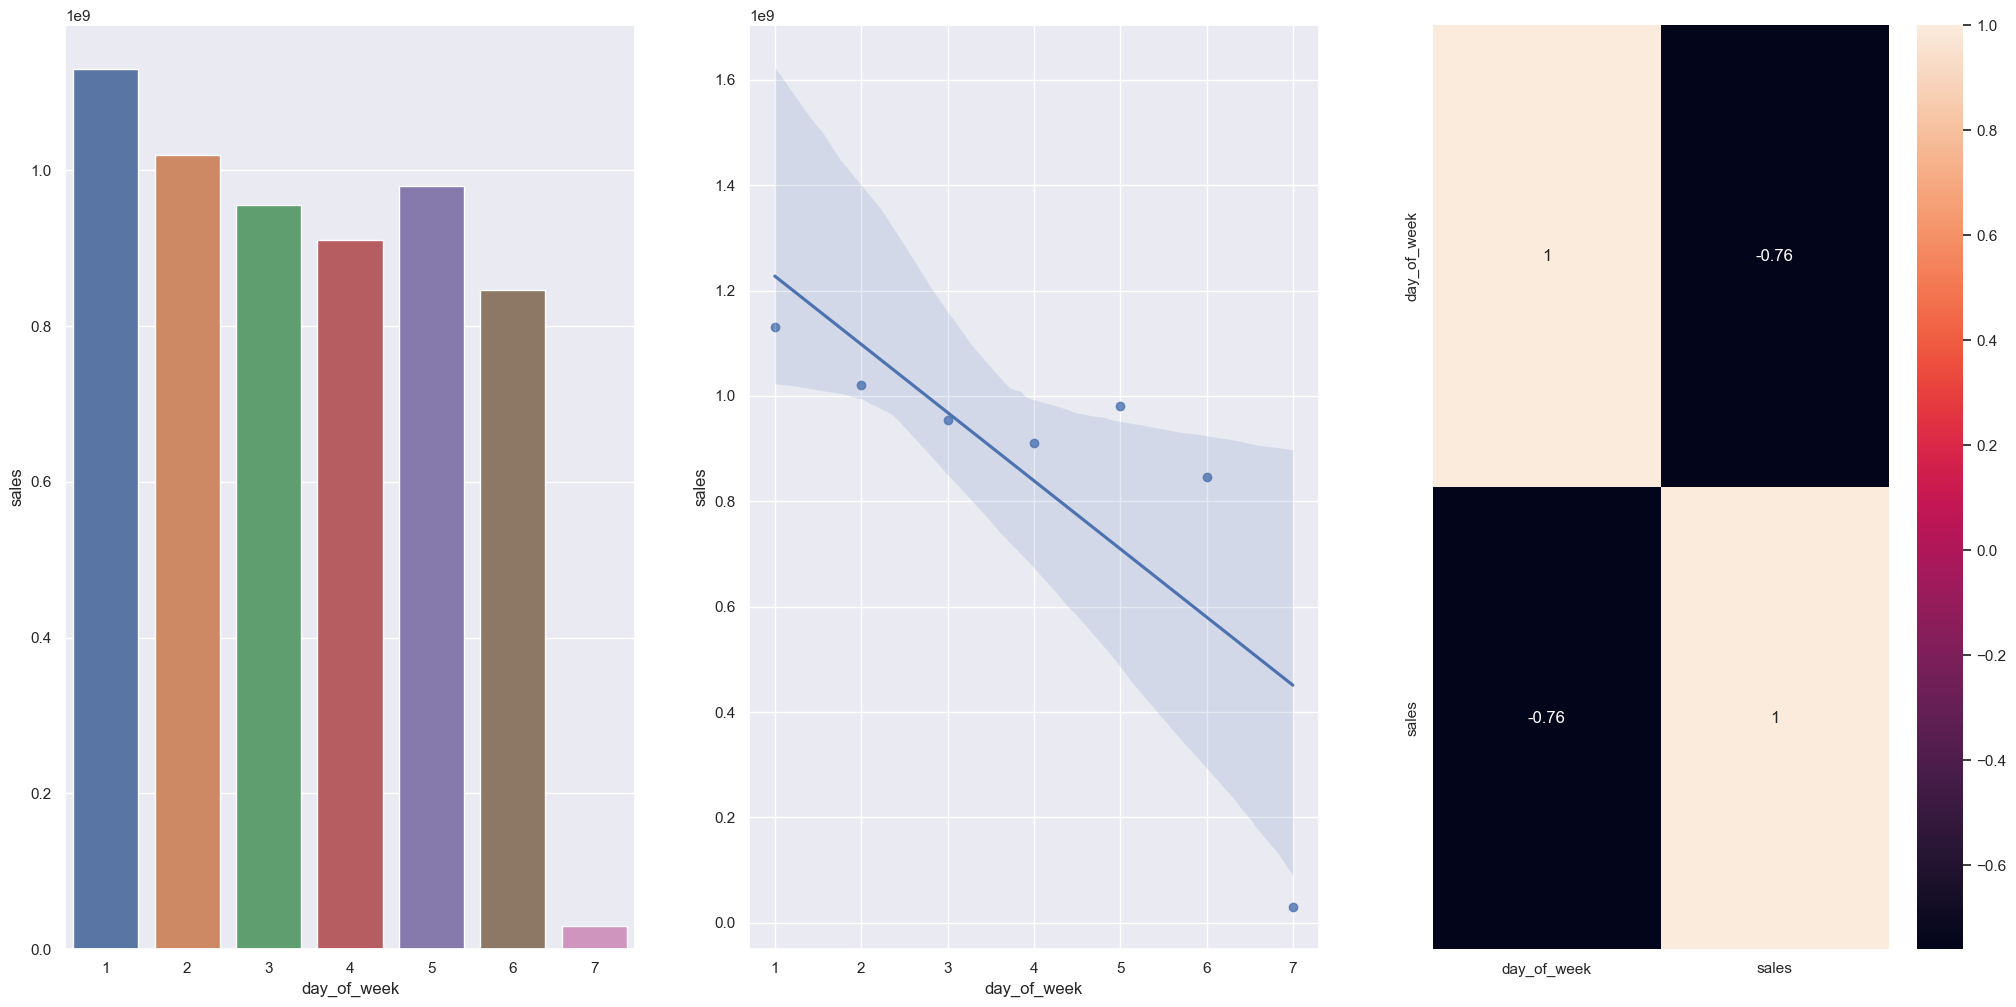

In [91]:
aux1 = df4[ [ 'day_of_week', 'sales' ] ].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(data = aux1, x = 'day_of_week', y = 'sales');

plt.subplot(1, 3, 2)
sns.regplot(data = aux1, x = 'day_of_week', y = 'sales');

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method='pearson'), annot = True);

### **H12.** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Lojas vendem MENOS durante os feriados escolares, exceto os meses de Julho e Agosto.

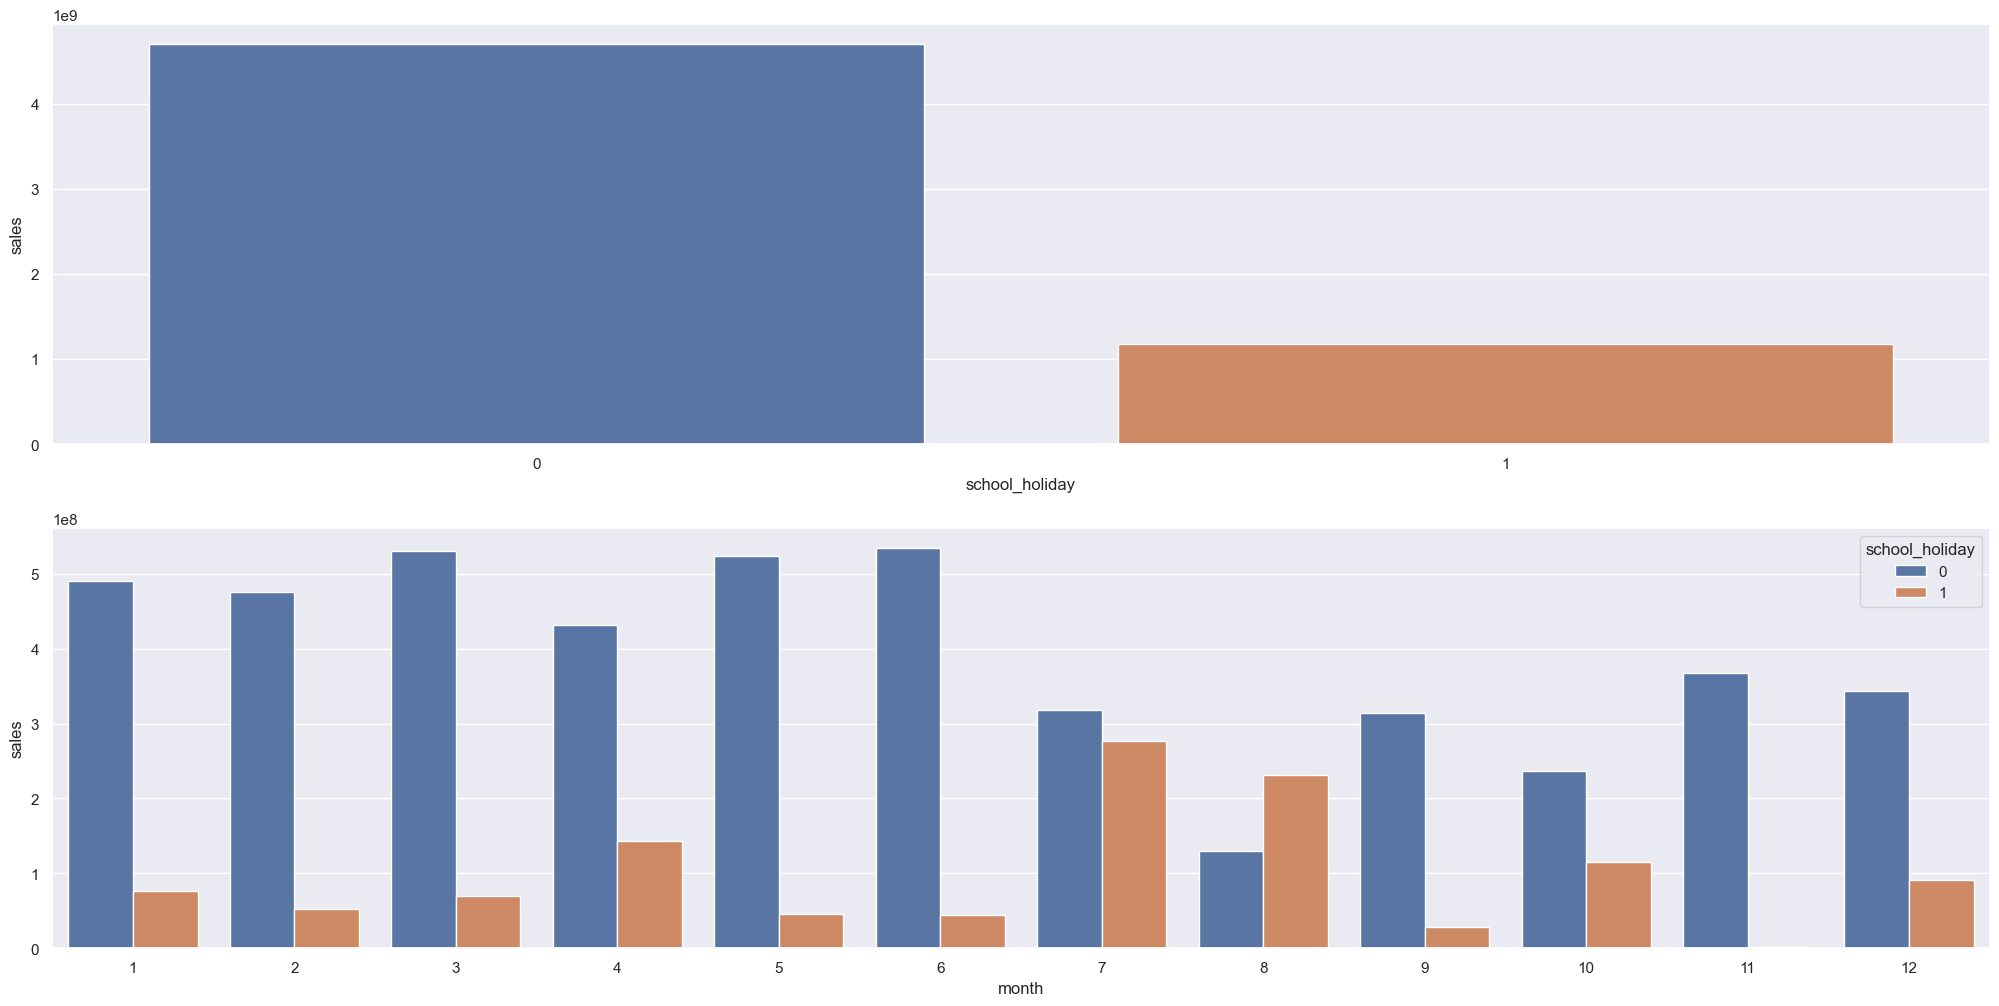

In [97]:
plt.subplot(2, 1, 1)
aux1 = df4[ ['school_holiday', 'sales'] ].groupby('school_holiday').sum().reset_index()
sns.barplot( data = aux1, x = 'school_holiday', y = 'sales');

plt.subplot(2, 1, 2)
aux2 = df4[ ['month', 'school_holiday', 'sales'] ].groupby( [ 'month', 'school_holiday' ] ).sum().reset_index()
sns.barplot( data = aux2, x = 'month', y = 'sales', hue = 'school_holiday');